In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

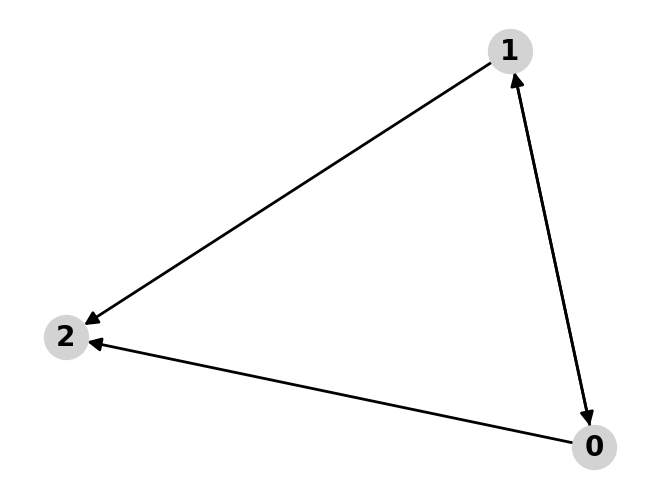

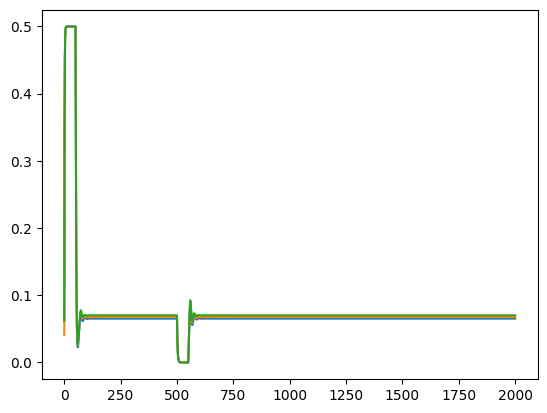

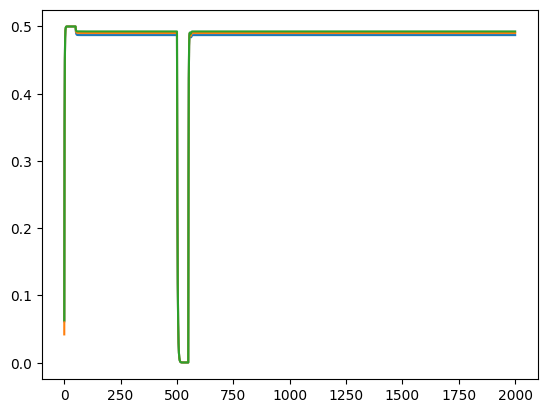

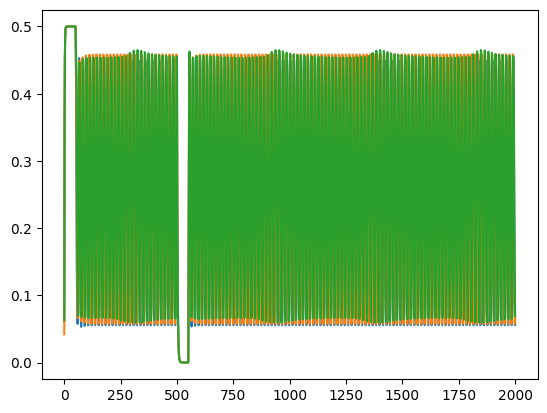

period =  15.43157894736842


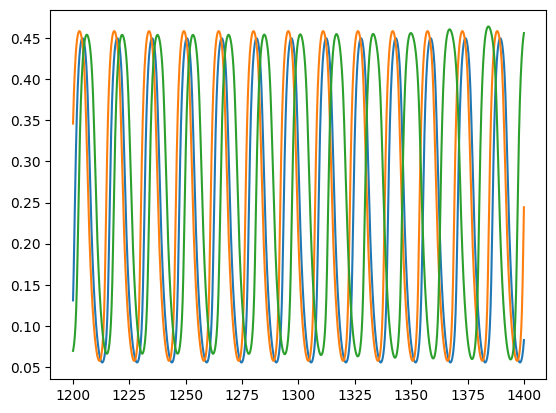

In [2]:
comp_points = [[1., 0.5], [3., 0.5], [2., 0.5]]

cmat = np.array( [[0., 0.5, 0.], [1., 0., 0.], [1., 0.5, 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 12., 0.], [10., 0., 0.], [10., 4., 0.]] ) # delay from 0 to 1

N = cmat.shape[0]
dir = "images_3n"

G = nx.DiGraph() 
for n in range(cmat.shape[0]):
        for l in range(cmat.shape[1]):
            if cmat[n,l] != 0:
                G.add_edge(l,n)
nx.draw(G, with_labels=True, arrows=True, **options)
plt.savefig(os.path.join(dir, "network.png"), bbox_inches='tight')
plt.show()


colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 2000 # Simulation time, ms
model.params.signalV = 1.

zero_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
rect_input = np.vstack( (zero_input)*2 )
rect_input[0,:500] = 5.
rect_input[0,5000:5500] = -5.

for p in comp_points:
    model.params["exc_ext"] = p[0] + rect_input[0,:]
    model.params["inh_ext"] = p[1]
    model.run()

    for n in range(N):
        plt.plot(model.t, model.exc[n,:], color=colors[n])
    plt.show()

    if p[0] == 2.:

        peaks = scipy.signal.find_peaks(model.exc[0,2000:5000])[0]
        plist = []
        for pind in range(1, len(peaks)):
            plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

        period = np.mean(plist)
        print("period = ", period)

        peaksn = [None]*N

        for n in range(N):
            peaksn[n] = scipy.signal.find_peaks(model.exc[n,4000:5000])[0]

        for n in range(N):
            plt.plot(model.t[12000:14000], model.exc[n,12000:14000], color=colors[n])
        plt.show()


In [3]:
def getperiods(x, prominence):
    timing_list = [None] * N
    periods_list = [None] * N

    for n in range(N):
        timing_list[n] = scipy.signal.find_peaks(x[n, 0, 300:], prominence=prominence)[0]
        periods_list[n] = []
        if len(timing_list[n]) < 3:
            continue
        for pind in range(1, len(timing_list[n])):
            periods_list[n].append(model.params.dt * (timing_list[n][pind]-timing_list[n][pind-1]))

    return timing_list, periods_list

In [4]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

w2_array = [1e-3, 1e-5]

results = dict()
results["controls"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]

target_array = [0.5*period, 0.9*period, period, 1.1*period, 1.6*period]
results["periods"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]
results["timings"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]

(1, 2001) (1, 2, 2001) (3, 2, 2001)


In [12]:
it = 100
pr = np.arange(0,101,10)
maxstr = 10.
nmaxdel = model.getMaxDelay()
proms = [0.01, 0.001]

init_control = zero_control.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03386433949772211
Cost in iteration 10: -0.19004843364721713
Converged in iteration 12 with cost -0.19041045229472195
Final cost : -0.19041045229472195


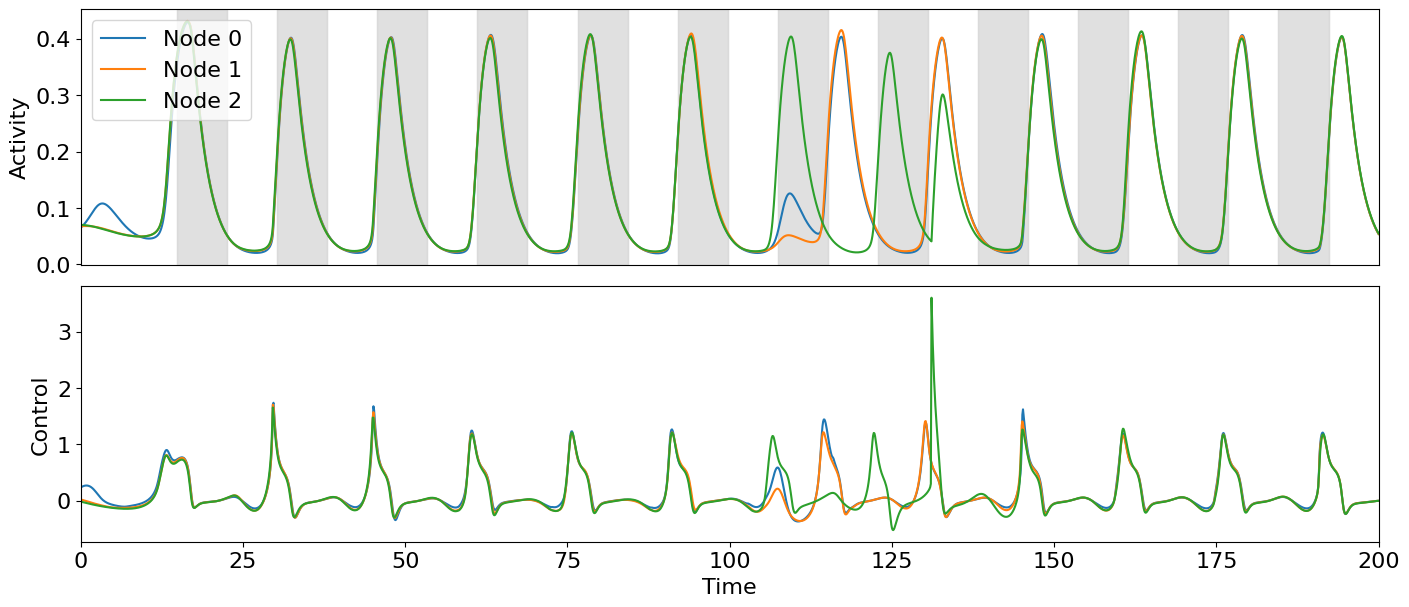

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.17010810148240266
Cost in iteration 10: -0.4276347628090571
Cost in iteration 20: -0.5196788305117471
Cost in iteration 30: -0.5199056254820477
Cost in iteration 40: -0.5199973926295445
Cost in iteration 50: -0.5200472113307987
Cost in iteration 60: -0.5200977344171611
Cost in iteration 70: -0.5201550048977499
Cost in iteration 80: -0.5202089287586501
Cost in iteration 90: -0.5202556098507746
Converged in iteration 92 with cost -0.5202593321969152
Final cost : -0.5202593321969152


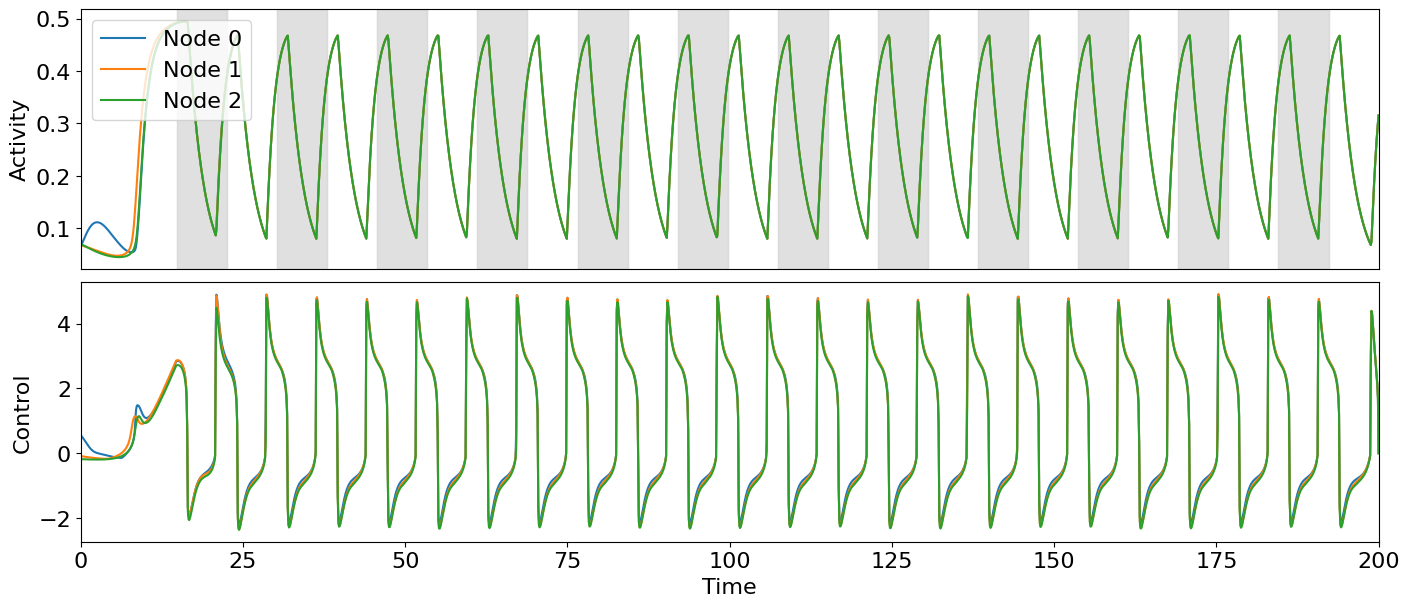

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2914072355460453
Cost in iteration 10: -0.5289848827862913
Cost in iteration 20: -0.5346524770377467
Converged in iteration 24 with cost -0.5349836186825383
Final cost : -0.5349836186825383


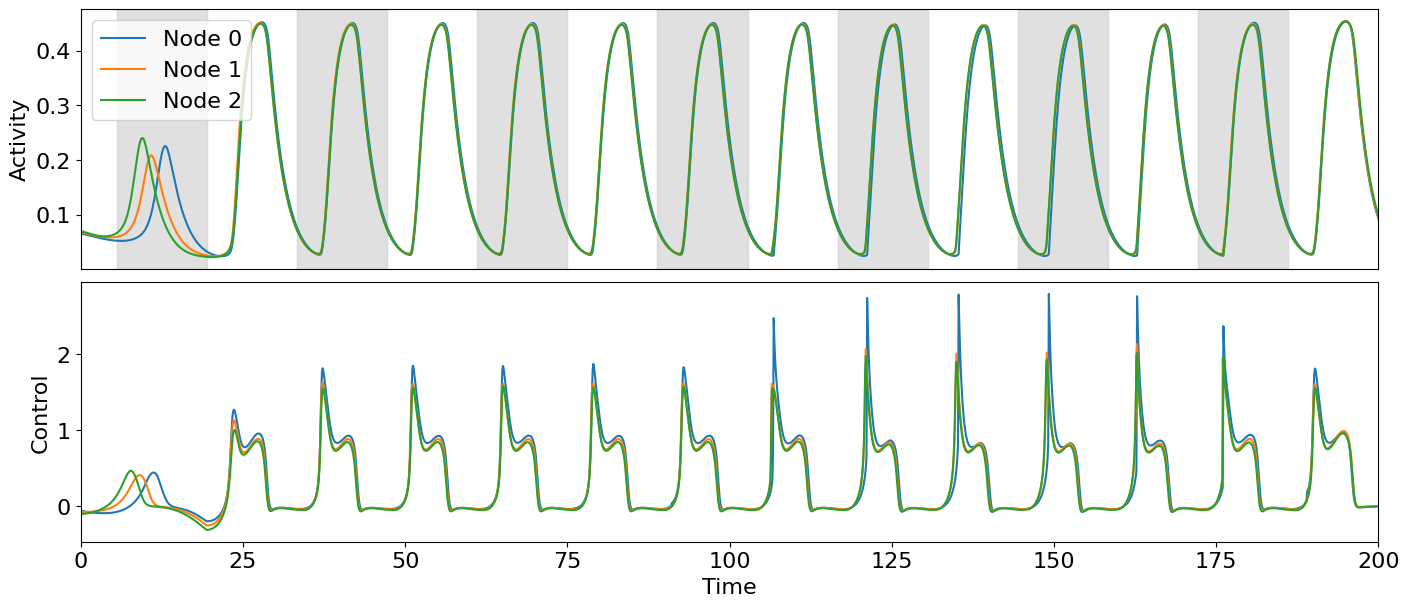

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.4542463576528815
Cost in iteration 10: -0.661697963735759
Cost in iteration 20: -0.7219339892278529
Cost in iteration 30: -0.7220479638335133
Cost in iteration 40: -0.7221602962123106
Cost in iteration 50: -0.7222726740168856
Cost in iteration 60: -0.7224027454848008
Cost in iteration 70: -0.7225289340665562
Cost in iteration 80: -0.7226913021826104
Cost in iteration 90: -0.7228409821666967
Cost in iteration 100: -0.7230142935779952
Final cost : -0.7230142935779952


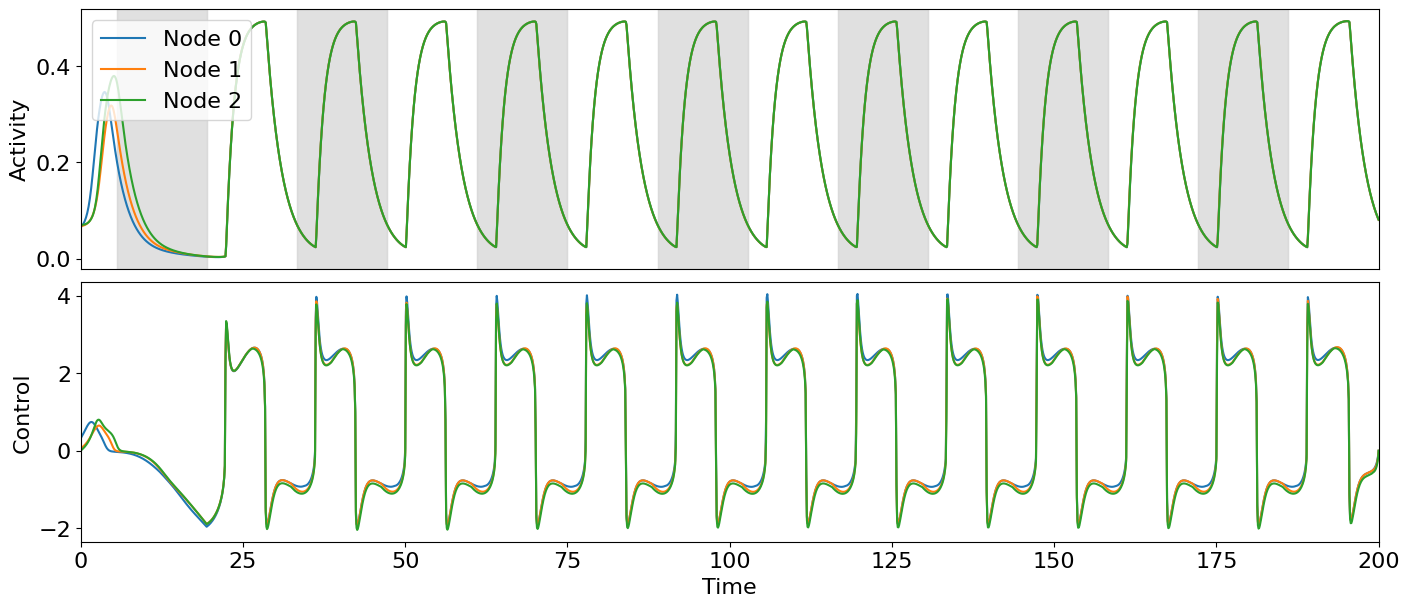

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.3023800754637993
Cost in iteration 10: -0.5532655902425946
Cost in iteration 20: -0.5589141487999273
Cost in iteration 30: -0.5591450936787106
Cost in iteration 40: -0.5592255778722377
Cost in iteration 50: -0.5592679249418395
Converged in iteration 52 with cost -0.5592688319113661
Final cost : -0.5592688319113661


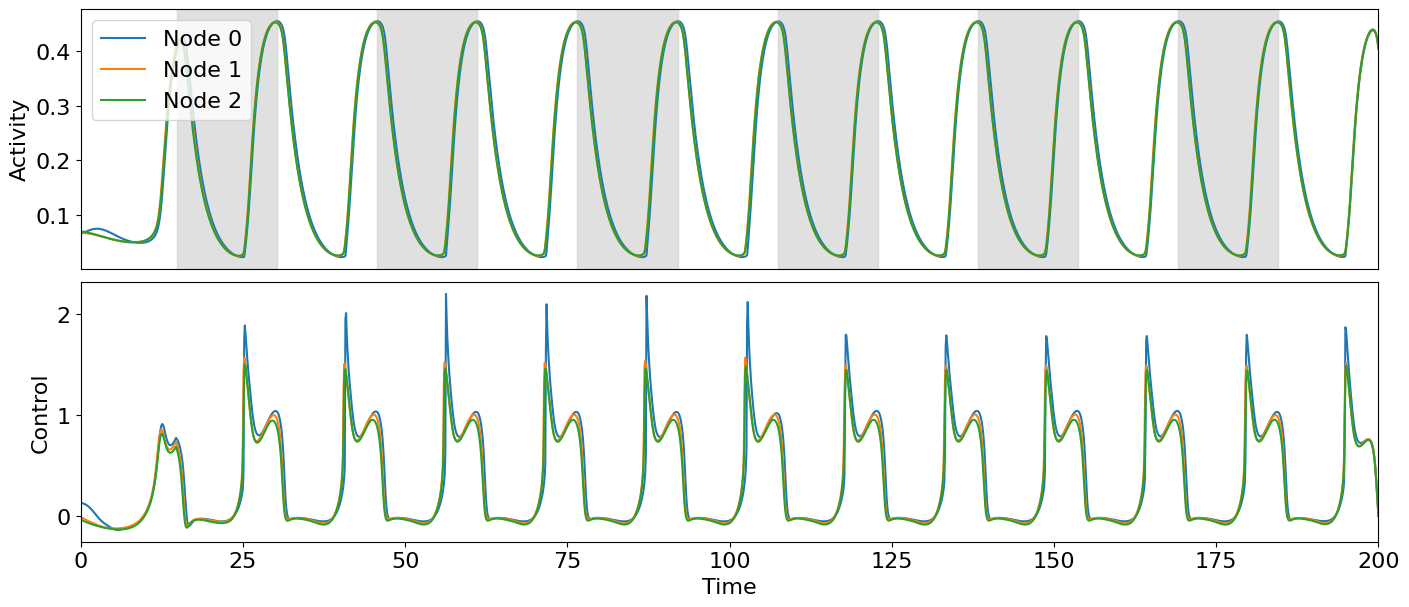

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.47609321486032513
Cost in iteration 10: -0.7001768478951137
Cost in iteration 20: -0.7481384660169479
Converged in iteration 30 with cost -0.7481501596857313
Final cost : -0.7481501596857313


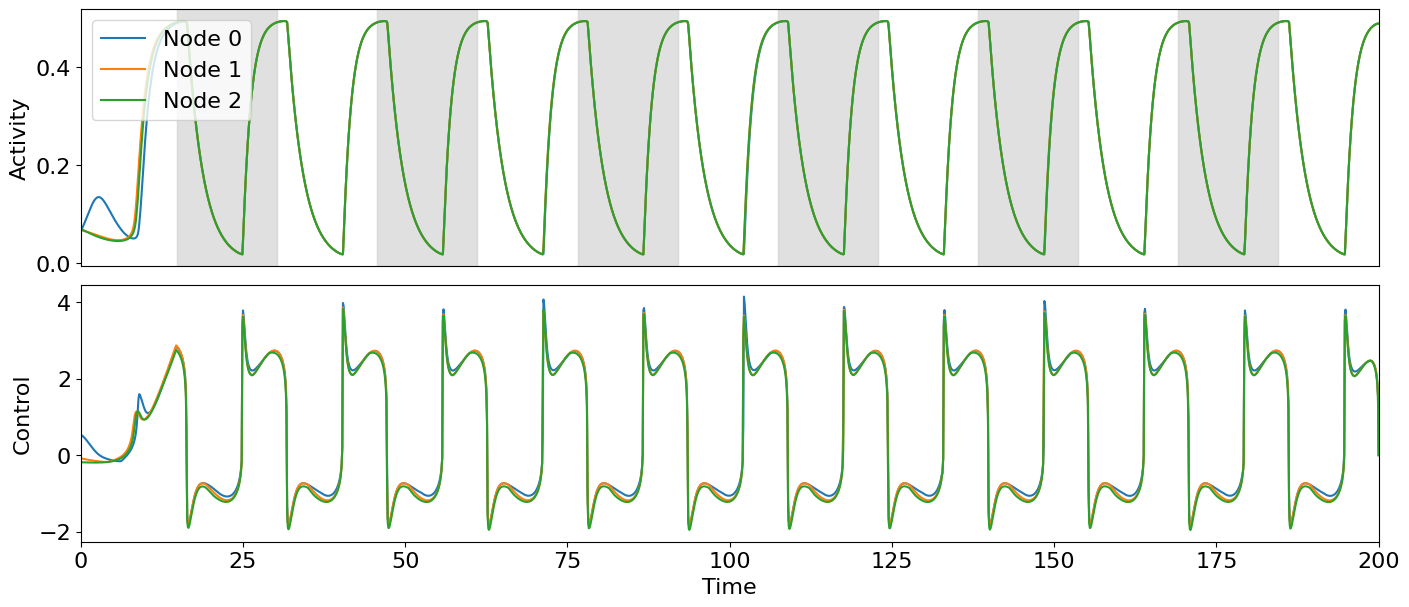

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.31691092435615054
Cost in iteration 10: -0.5798491960876418
Cost in iteration 20: -0.5808316884835256
Converged in iteration 30 with cost -0.5809428080814335
Final cost : -0.5809428080814335


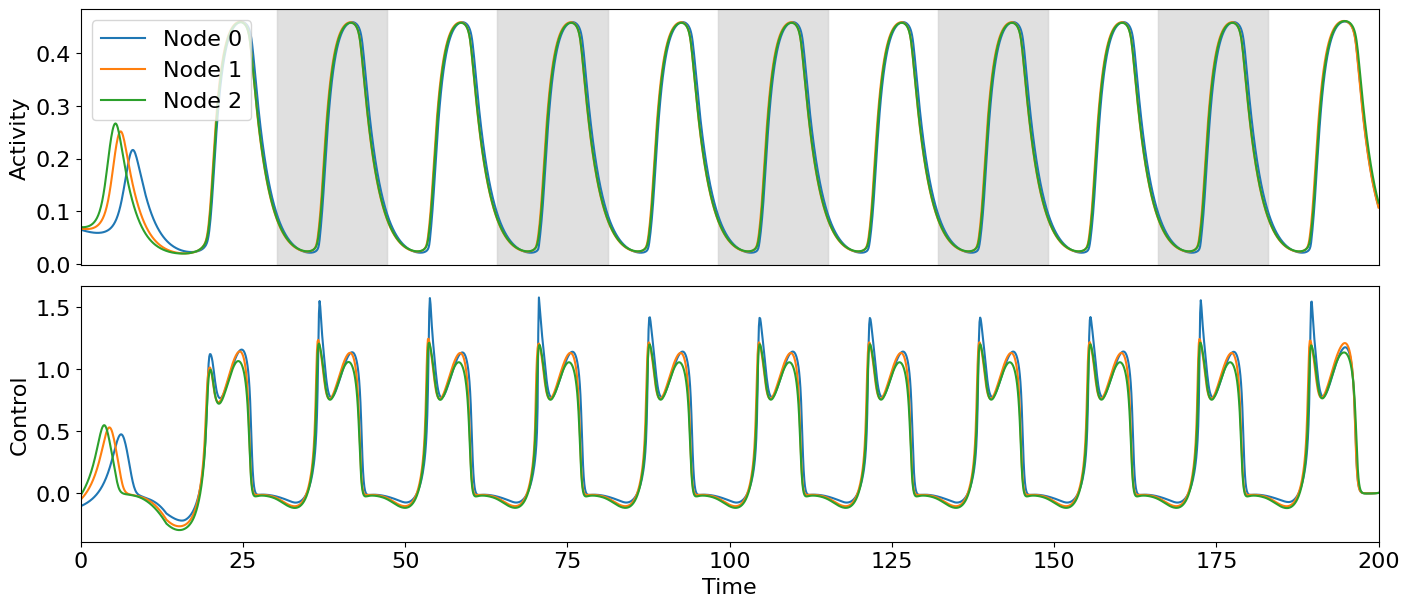

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.5033703123021155
Cost in iteration 10: -0.7277241067750115
Cost in iteration 20: -0.7797694868866927
Converged in iteration 28 with cost -0.780101562710387
Final cost : -0.780101562710387


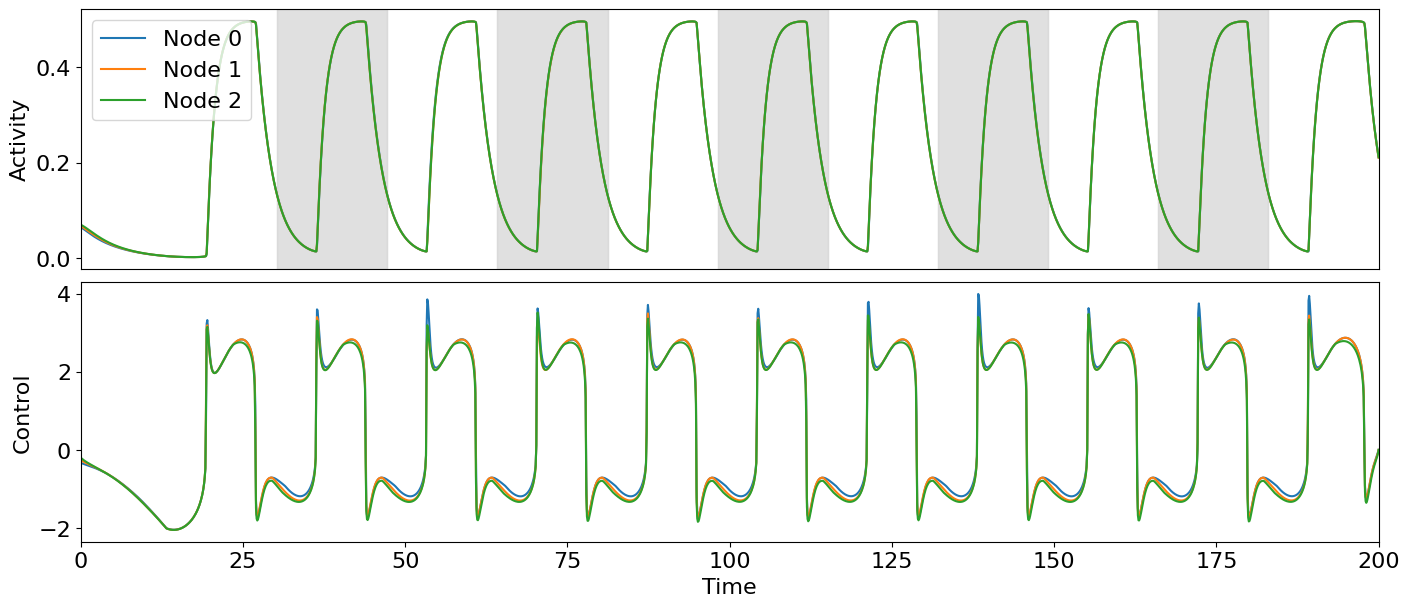

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.5849386592361783
Converged in iteration 5 with cost -0.5849403333485417
Final cost : -0.5849403333485417


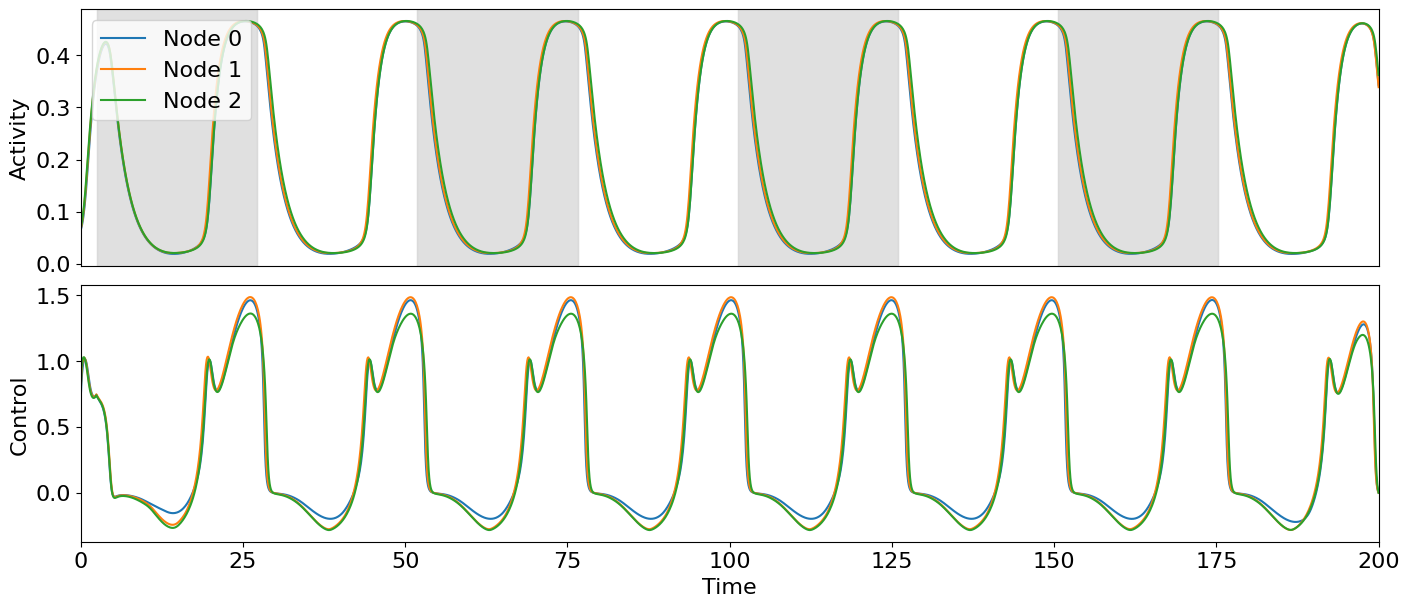

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.8405738866056618
Converged in iteration 3 with cost -0.840573886605662
Final cost : -0.840573886605662


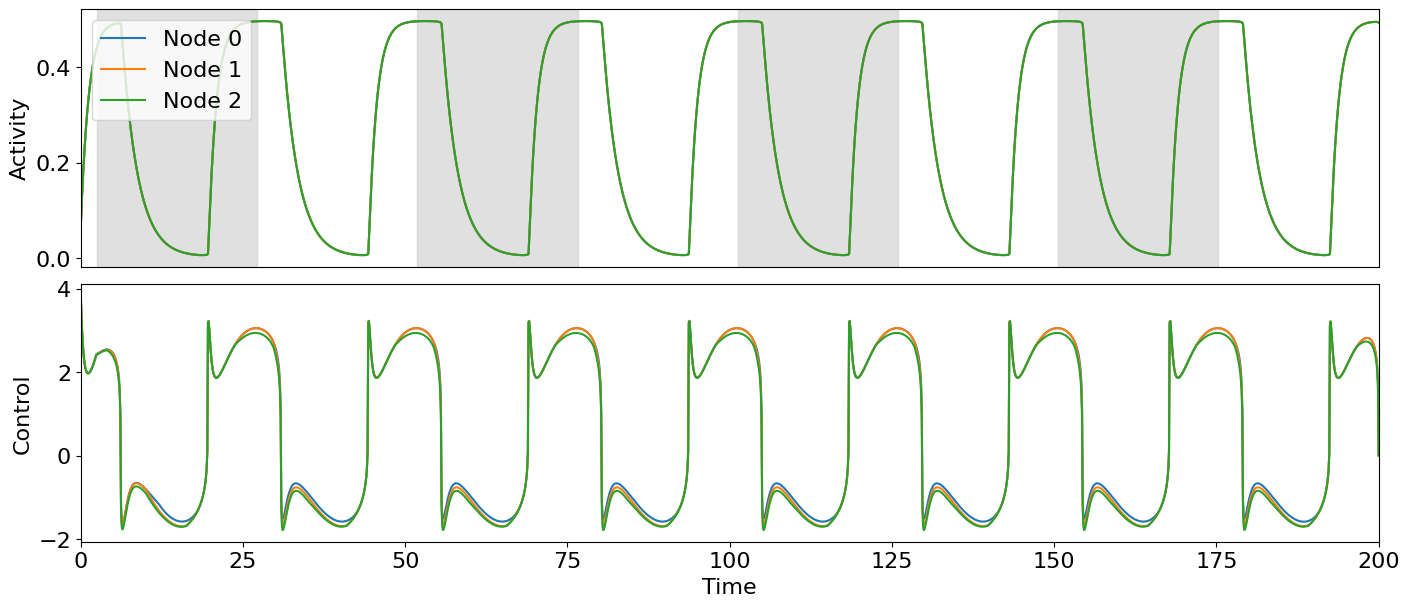

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.036676135546213046
Cost in iteration 10: -0.058349049993275705
Converged in iteration 11 with cost -0.058349049993275705
Final cost : -0.058349049993275705


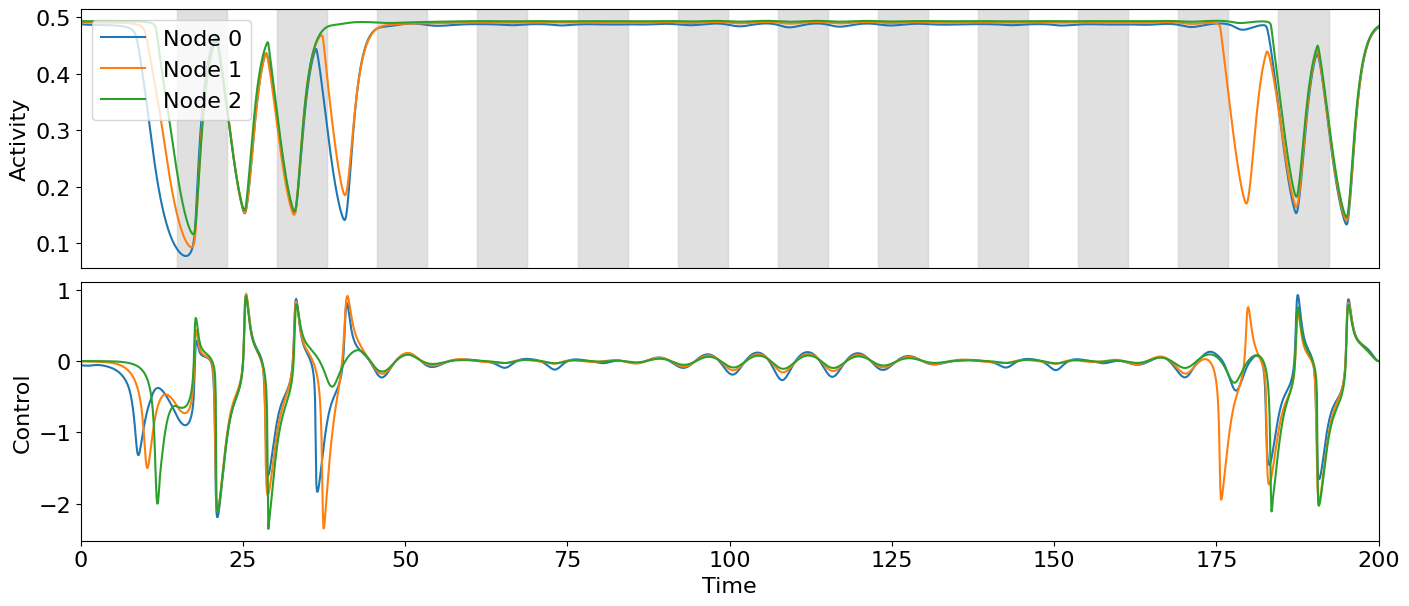

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.18016444309893287
Cost in iteration 10: -0.4366056623586867
Cost in iteration 20: -0.5242405359038886
Converged in iteration 25 with cost -0.5243540023564045
Final cost : -0.5243540023564045


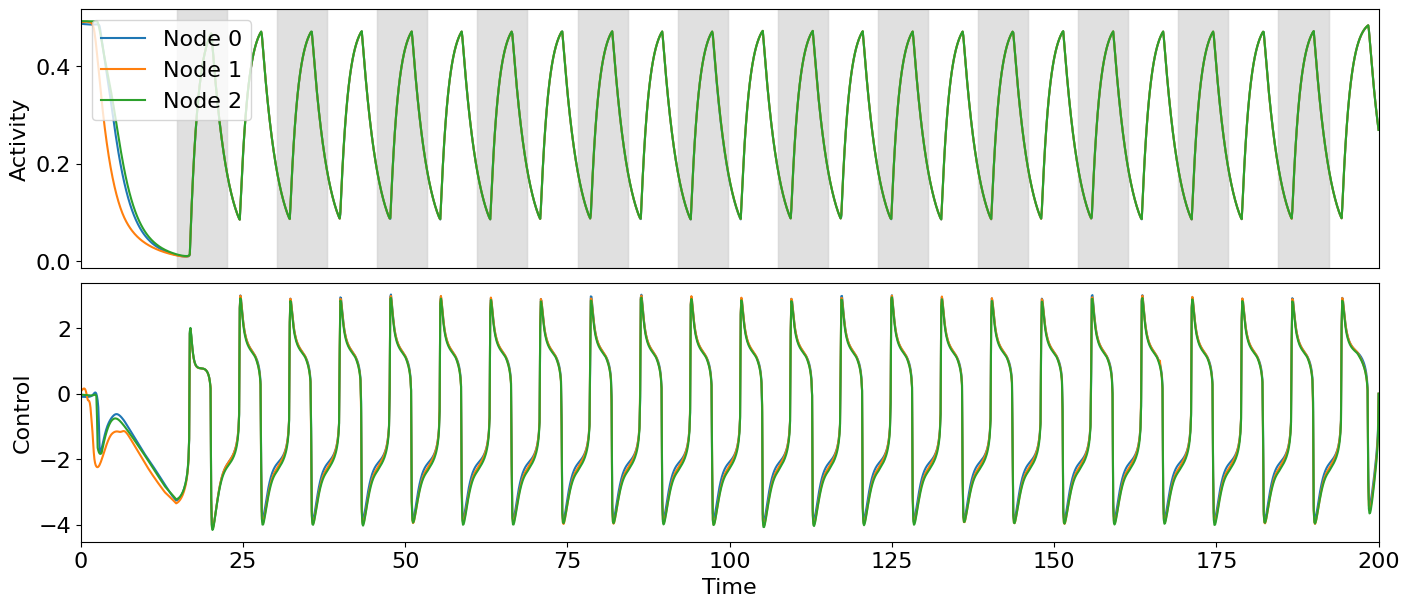

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2034994790185619
Cost in iteration 10: -0.25995326347495207
Cost in iteration 20: -0.2652368025562232
Cost in iteration 30: -0.2812041866570941
Cost in iteration 40: -0.28440802333574766
Converged in iteration 50 with cost -0.28699841685583366
Final cost : -0.28699841685583366


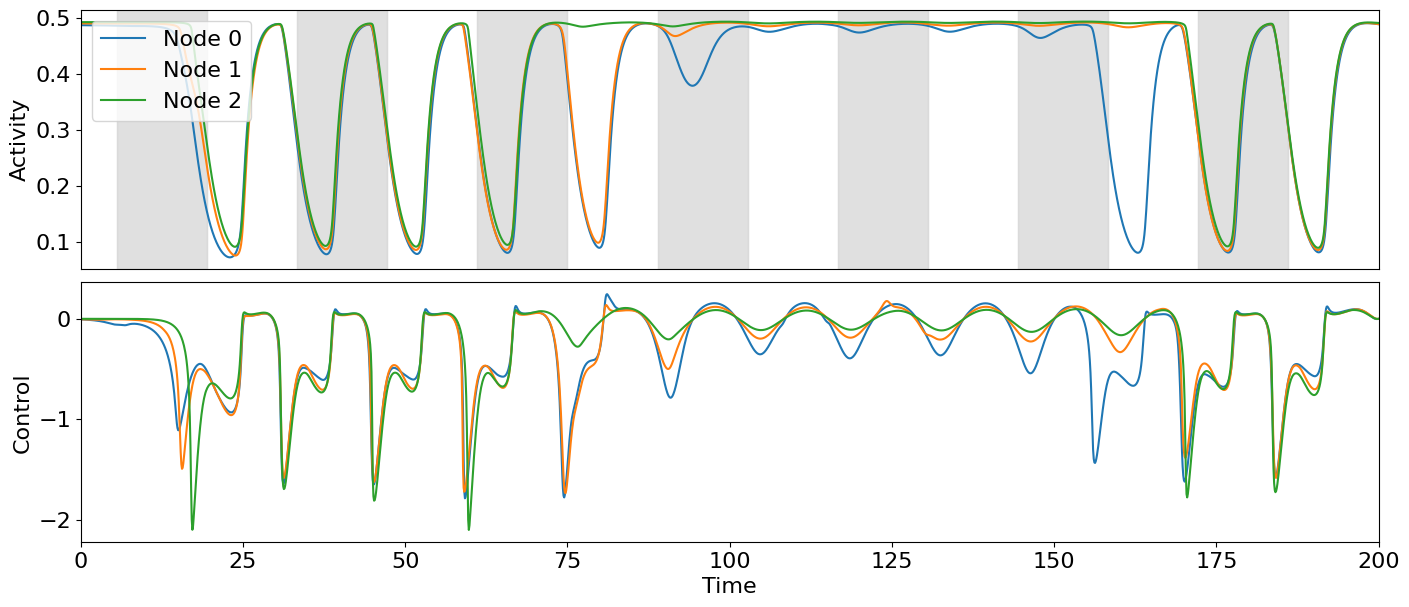

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.4514162232297016
Cost in iteration 10: -0.680204337230274
Cost in iteration 20: -0.7205919444936979
Cost in iteration 30: -0.7207273880015053
Cost in iteration 40: -0.7207646235079529
Cost in iteration 50: -0.720799157354311
Converged in iteration 57 with cost -0.7208325564565637
Final cost : -0.7208325564565637


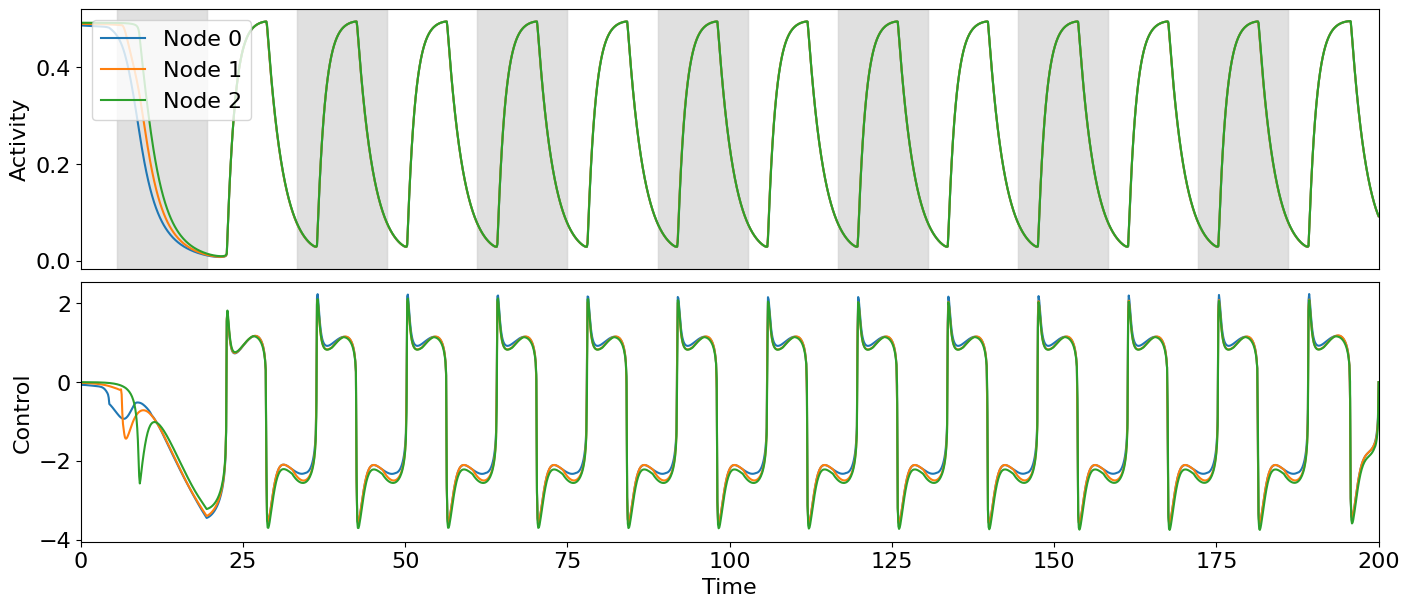

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.20888788870566605
Cost in iteration 10: -0.283727827526348
Converged in iteration 12 with cost -0.2853043808952673
Final cost : -0.2853043808952673


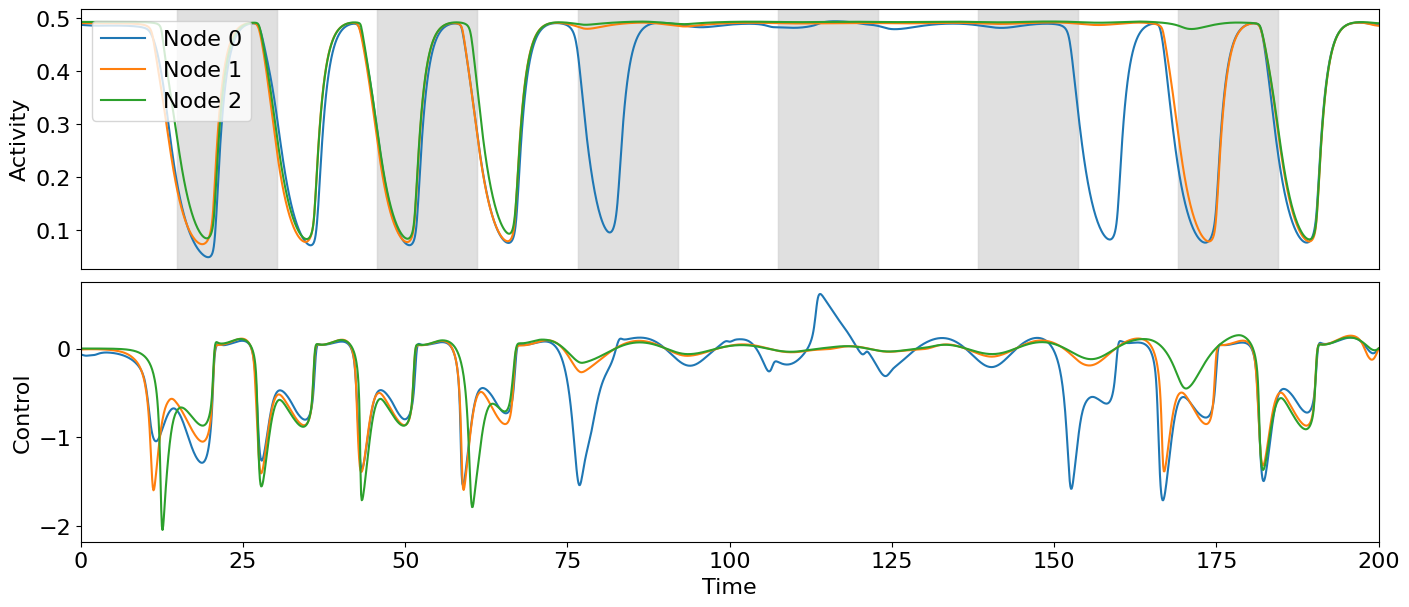

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.46949735097840883
Cost in iteration 10: -0.7024293482527528
Cost in iteration 20: -0.7477532921040564
Cost in iteration 30: -0.7478492857005323
Cost in iteration 40: -0.7478996384798386
Cost in iteration 50: -0.7479431046664157
Cost in iteration 60: -0.7479739057575342
Cost in iteration 70: -0.7480092339410843
Cost in iteration 80: -0.7480417853715099
Converged in iteration 84 with cost -0.7480494300598987
Final cost : -0.7480494300598987


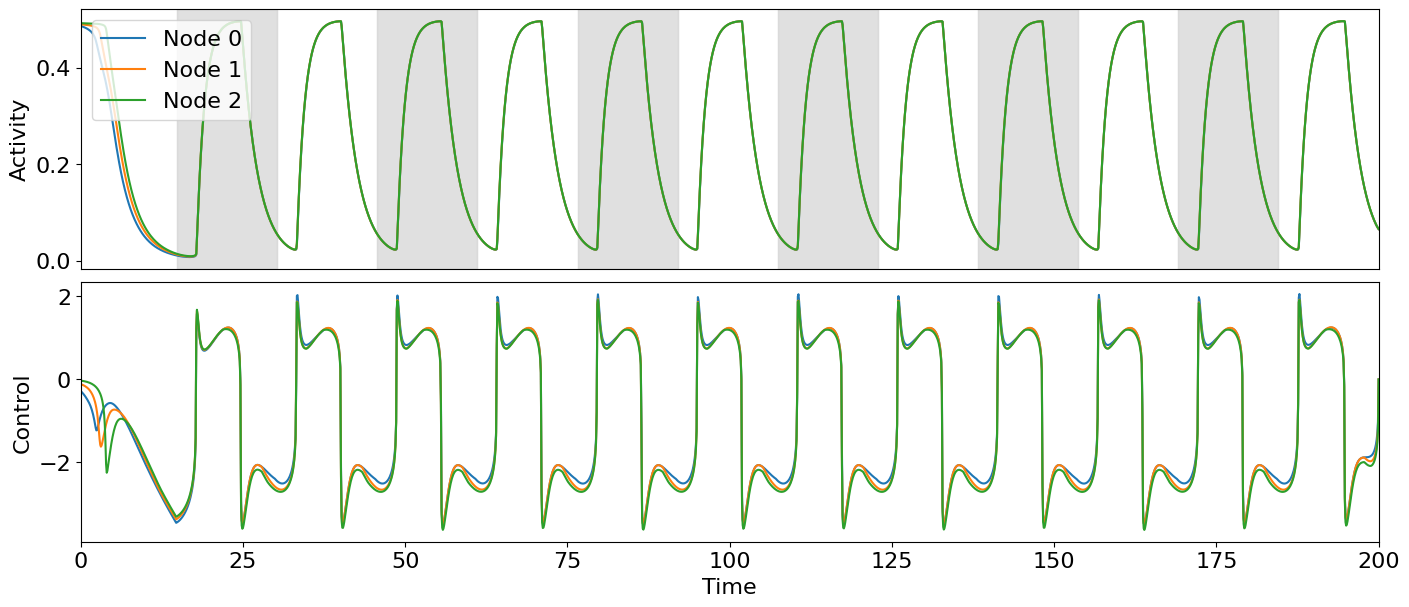

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.21092021324142923
Converged in iteration 9 with cost -0.26913051065034455
Final cost : -0.26913051065034455


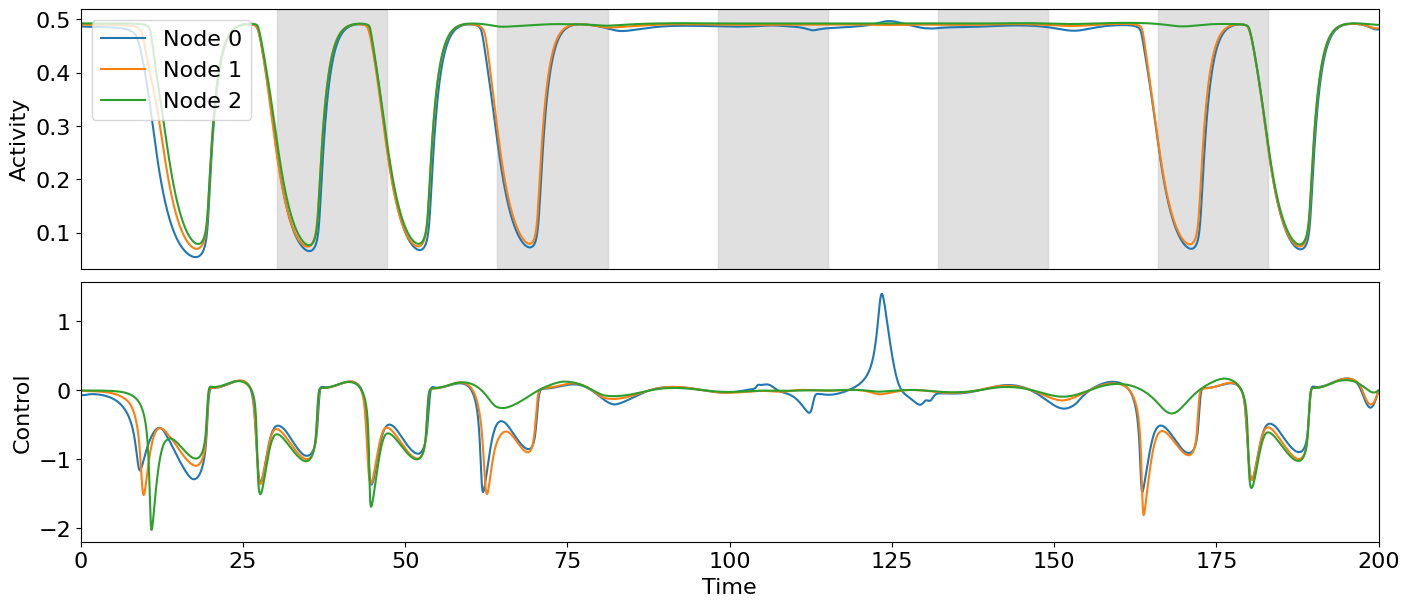

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.48411230824616497
Cost in iteration 10: -0.719836848844376
Converged in iteration 20 with cost -0.7701152367012077
Final cost : -0.7701152367012077


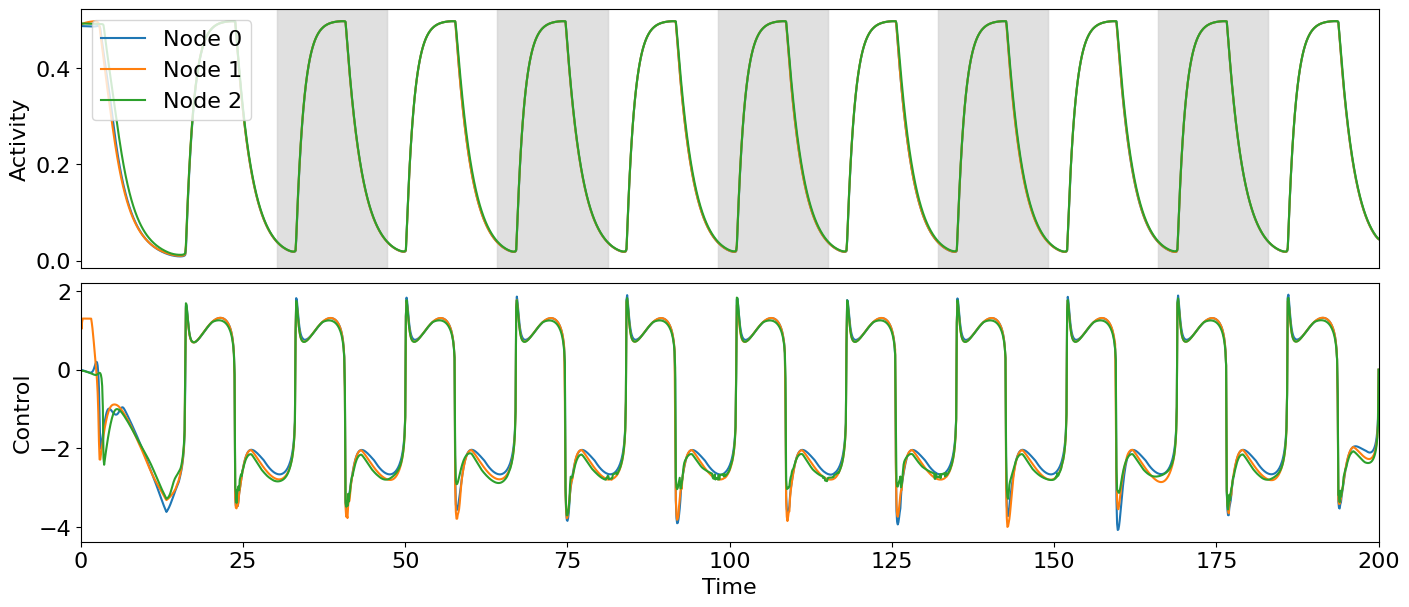

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.3339101246717171
Converged in iteration 9 with cost -0.33785666199730824
Final cost : -0.33785666199730824


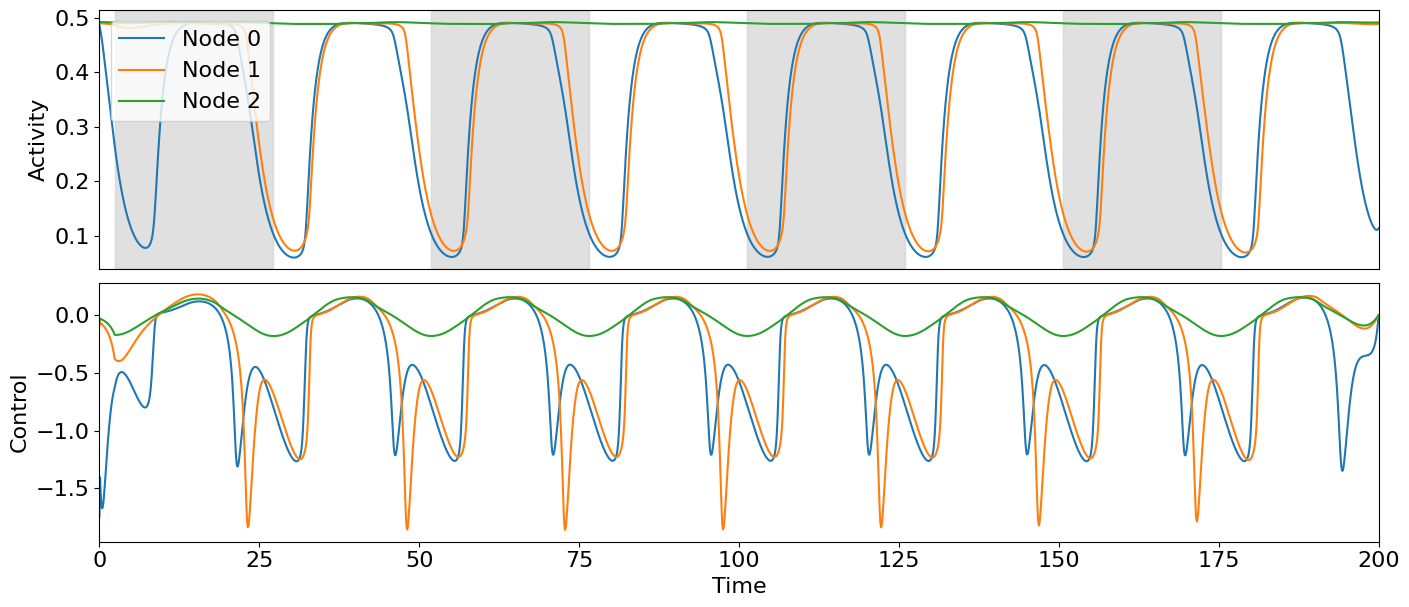

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.8301966547084618
Converged in iteration 3 with cost -0.8301966547084618
Final cost : -0.8301966547084618


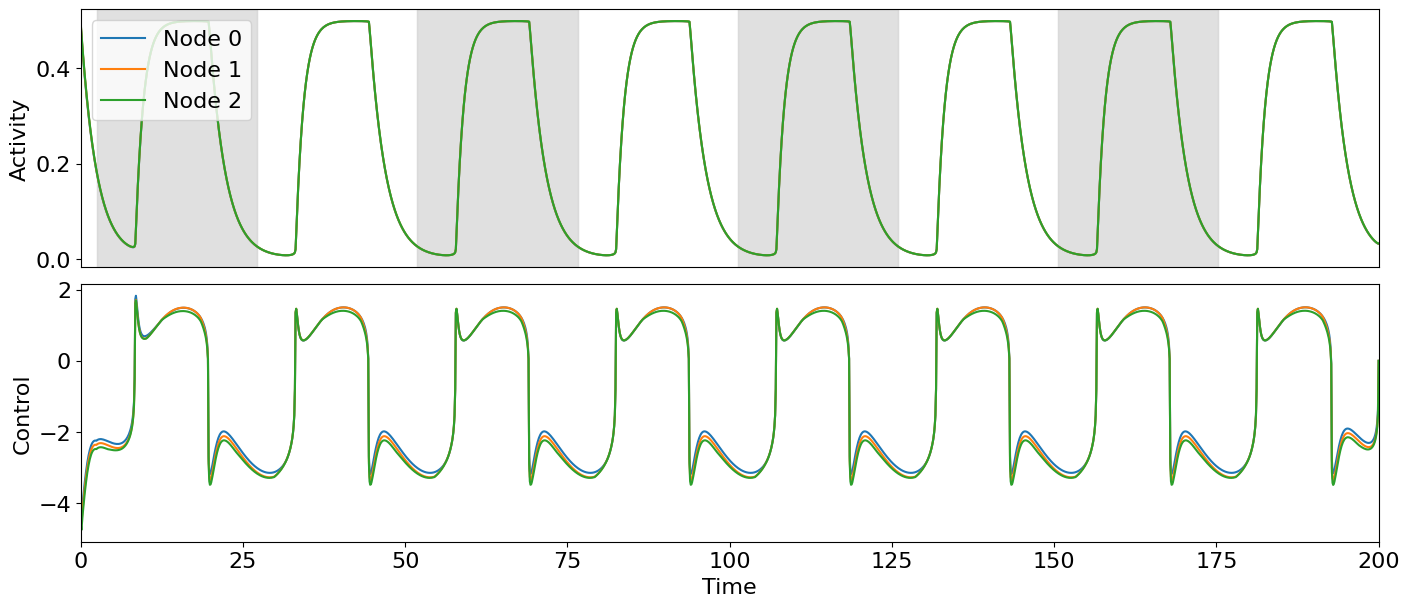

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04284610512471791
Cost in iteration 10: -0.16158187471667482
Cost in iteration 20: -0.18769136346098655
Cost in iteration 30: -0.195236143388348
Cost in iteration 40: -0.1981676096870374
Cost in iteration 50: -0.19914101151493152
Converged in iteration 51 with cost -0.19914101151493152
Final cost : -0.19914101151493152


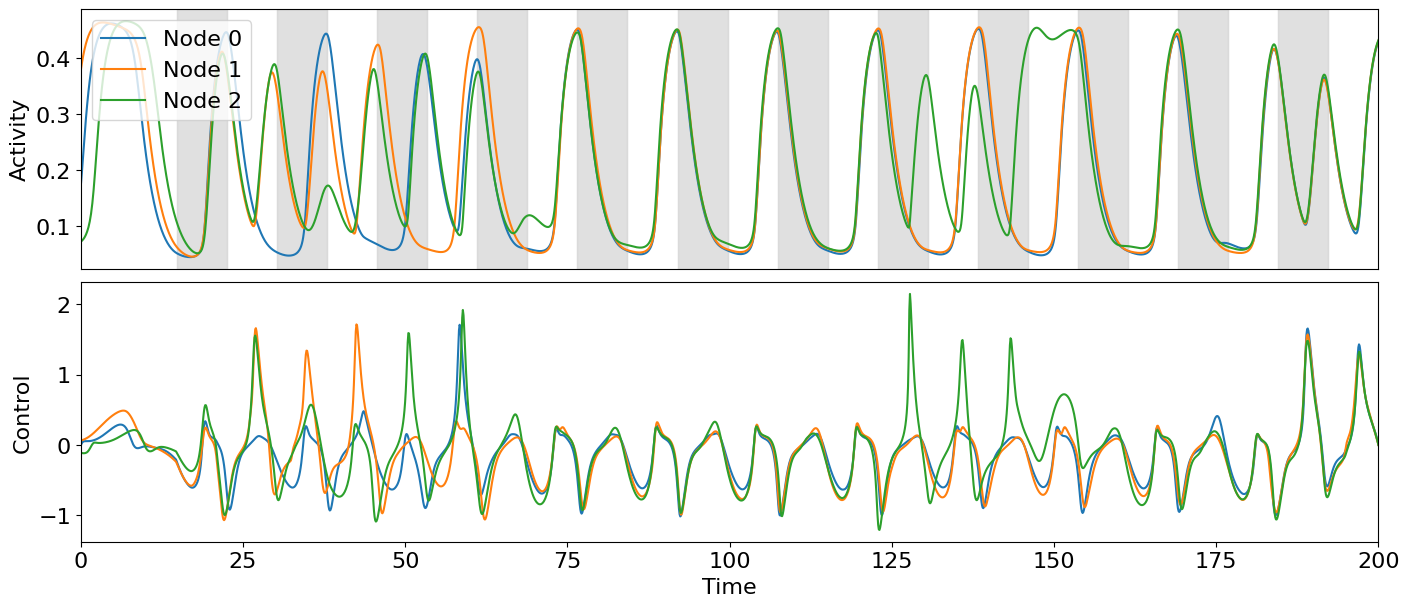

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2648835915762582
Cost in iteration 10: -0.46817975139820334
Cost in iteration 20: -0.5200379751661153
Cost in iteration 30: -0.5200879356208469
Cost in iteration 40: -0.5201162970036556
Cost in iteration 50: -0.5201494143632868
Cost in iteration 60: -0.5201585761998807
Cost in iteration 70: -0.5201660700957008
Cost in iteration 80: -0.5201870420021474
Cost in iteration 90: -0.5202010940759383
Cost in iteration 100: -0.5202082087098051
Final cost : -0.5202082087098051


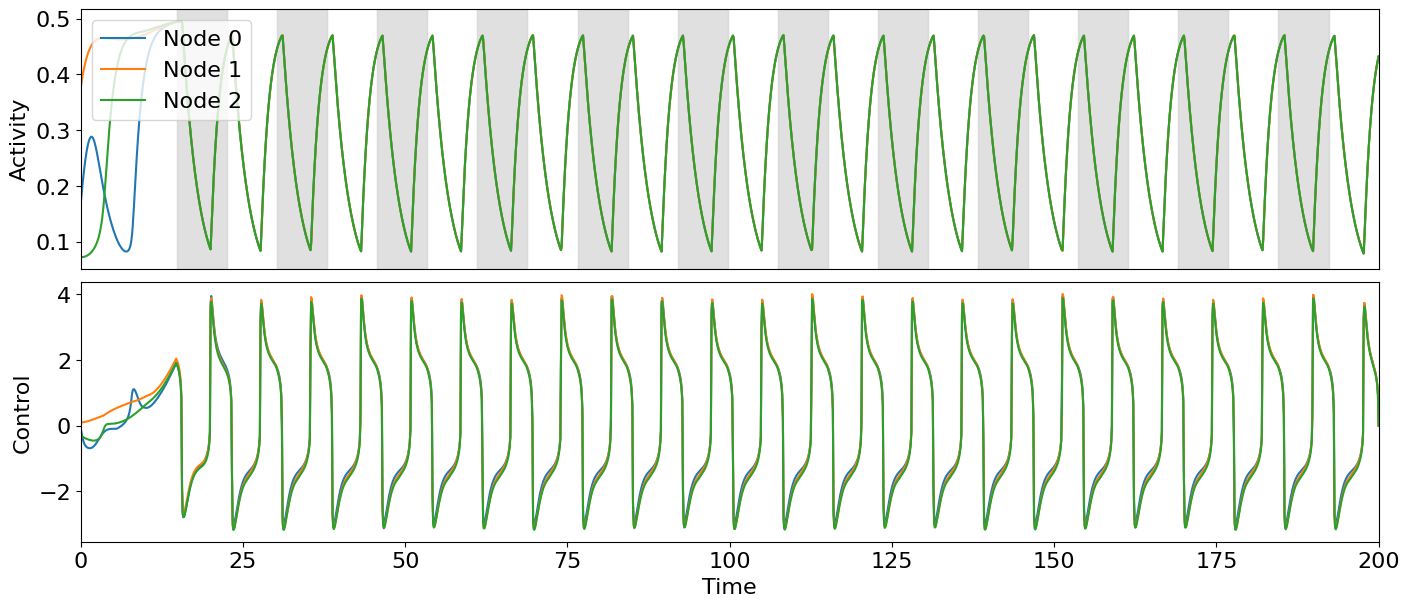

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.16803939623318548
Converged in iteration 9 with cost -0.6184255403342795
Final cost : -0.6184255403342795


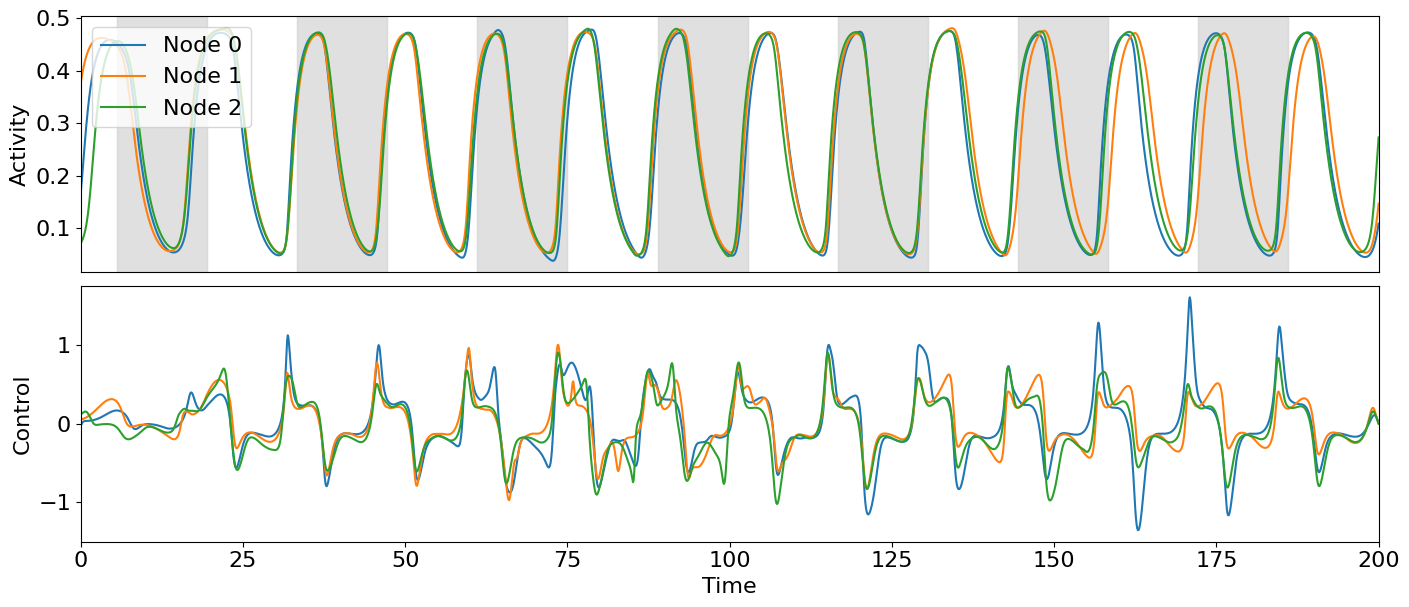

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.4557635211988522
Cost in iteration 10: -0.6864056934369199
Cost in iteration 20: -0.7213228277647129
Cost in iteration 30: -0.7213793542036177
Converged in iteration 36 with cost -0.7213903025434293
Final cost : -0.7213903025434293


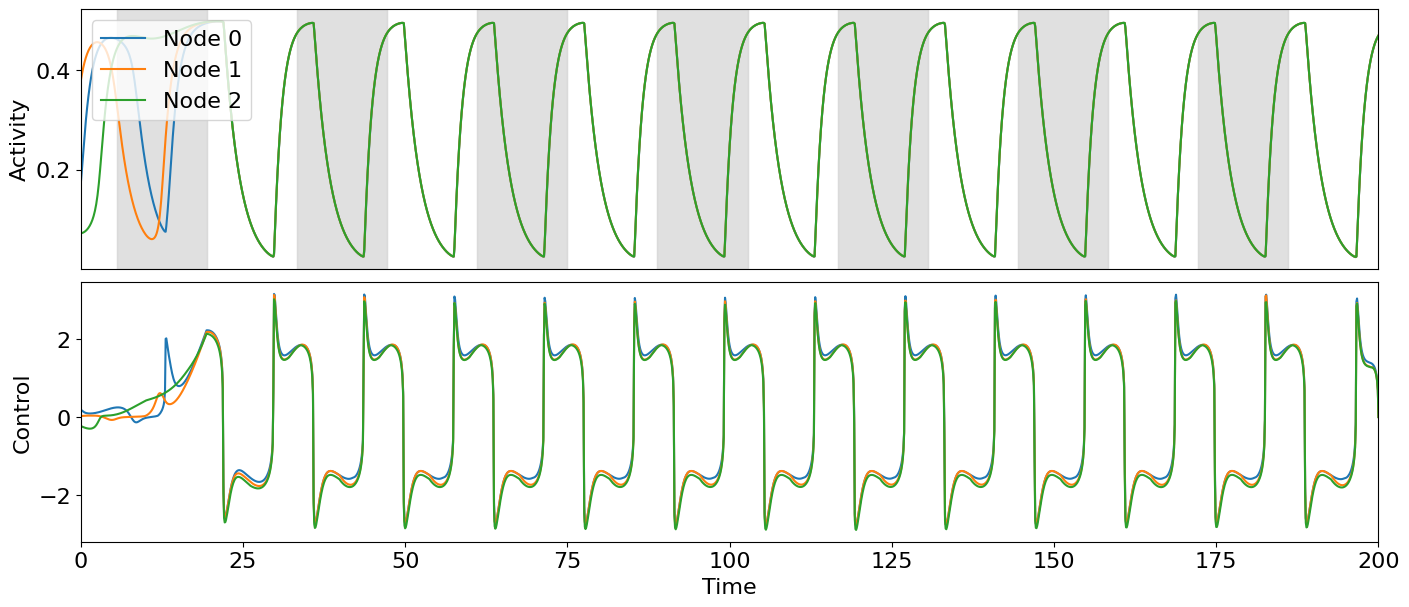

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.41221193523648547
Converged in iteration 9 with cost -0.6644687780716846
Final cost : -0.6644687780716846


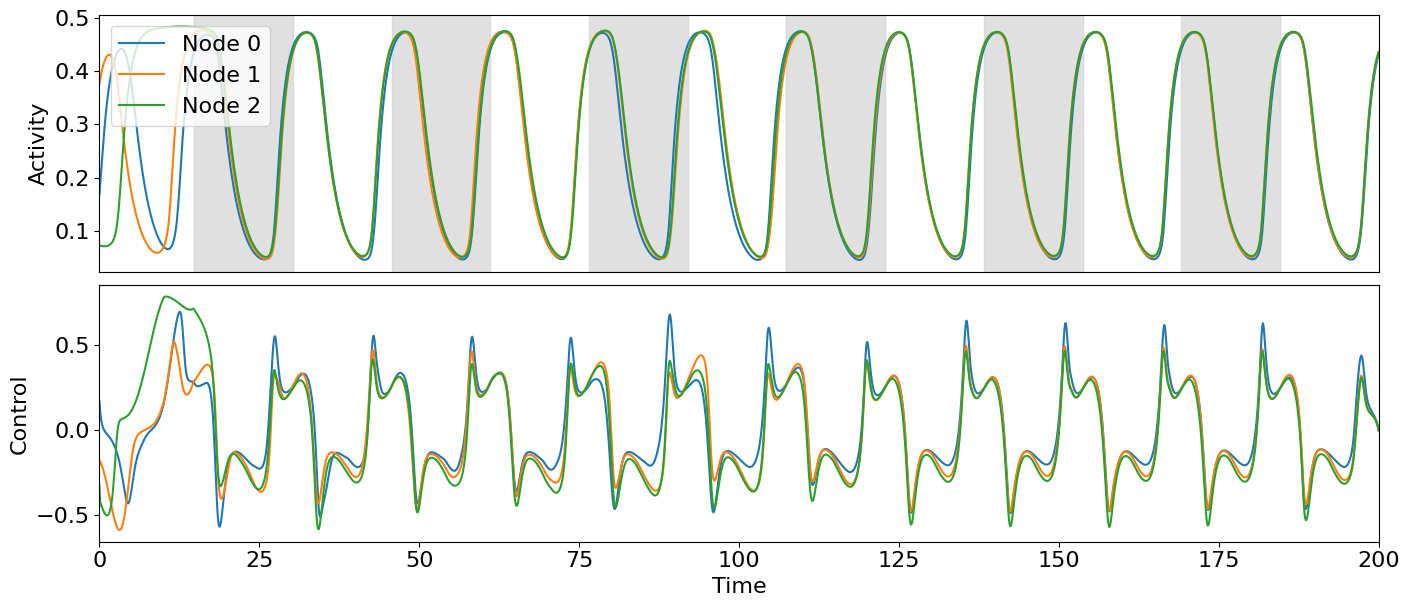

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.47726232058459106
Cost in iteration 10: -0.7114606119584597
Cost in iteration 20: -0.7496999131787013
Cost in iteration 30: -0.7497396276521889
Converged in iteration 34 with cost -0.7497423051171358
Final cost : -0.7497423051171358


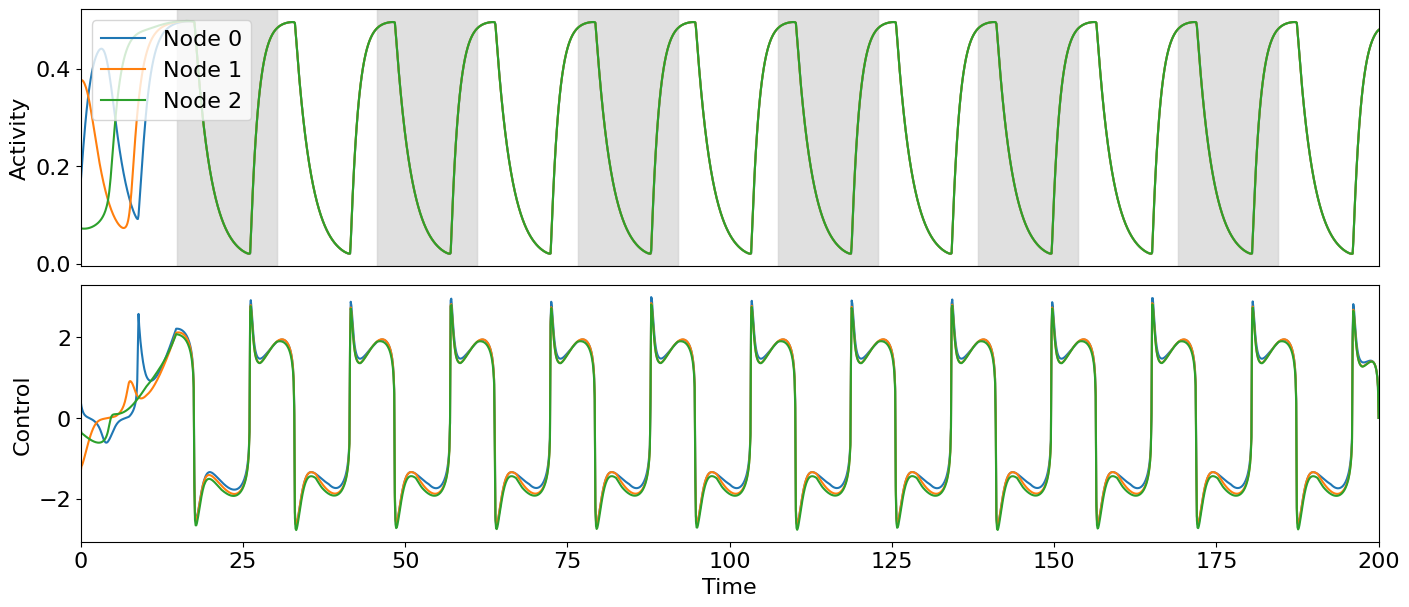

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.4248615508282316
Cost in iteration 10: -0.6839567638140454
Cost in iteration 20: -0.6911086221016877
Cost in iteration 30: -0.6913291765187304
Converged in iteration 40 with cost -0.6914062958988592
Final cost : -0.6914062958988592


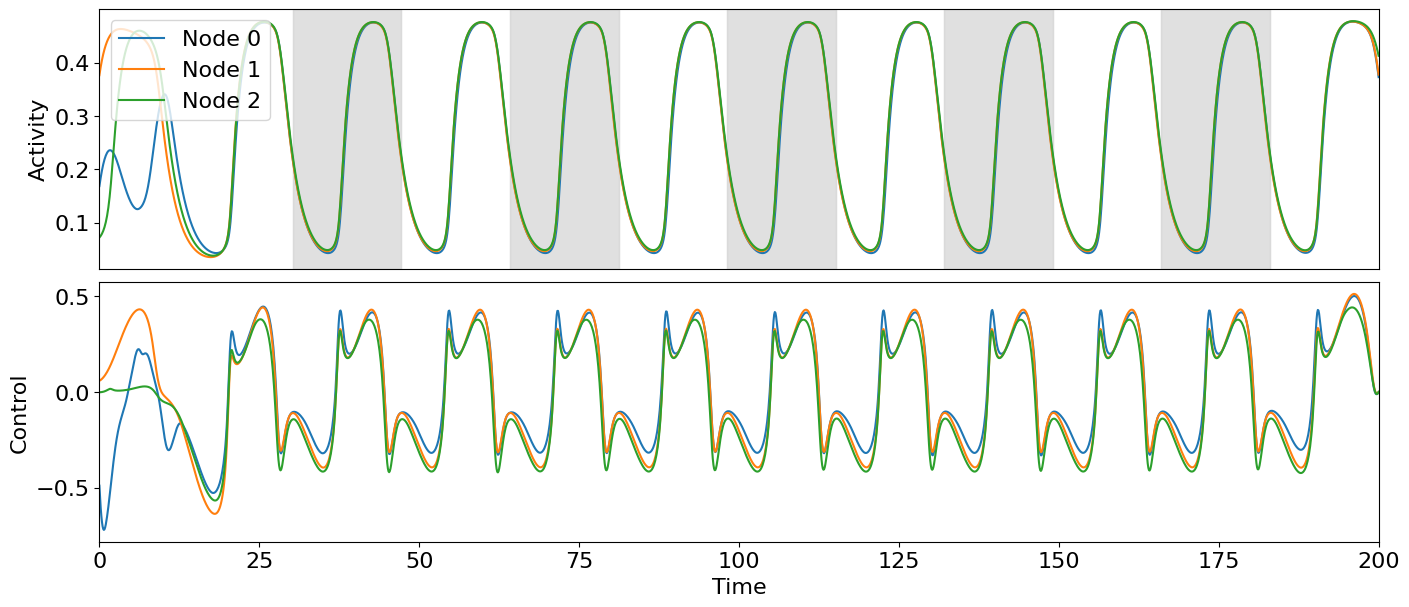

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.5018238187725046
Cost in iteration 10: -0.7419347610942012
Cost in iteration 20: -0.7831066839103744
Cost in iteration 30: -0.7832492685208318
Cost in iteration 40: -0.7832562625788086
Cost in iteration 50: -0.7832593813506636
Cost in iteration 60: -0.7832609236297158
Cost in iteration 70: -0.7832616876479014
Cost in iteration 80: -0.7832621620194866
Cost in iteration 90: -0.7832624494915578
Cost in iteration 100: -0.7832626406696553
Final cost : -0.7832626406696553


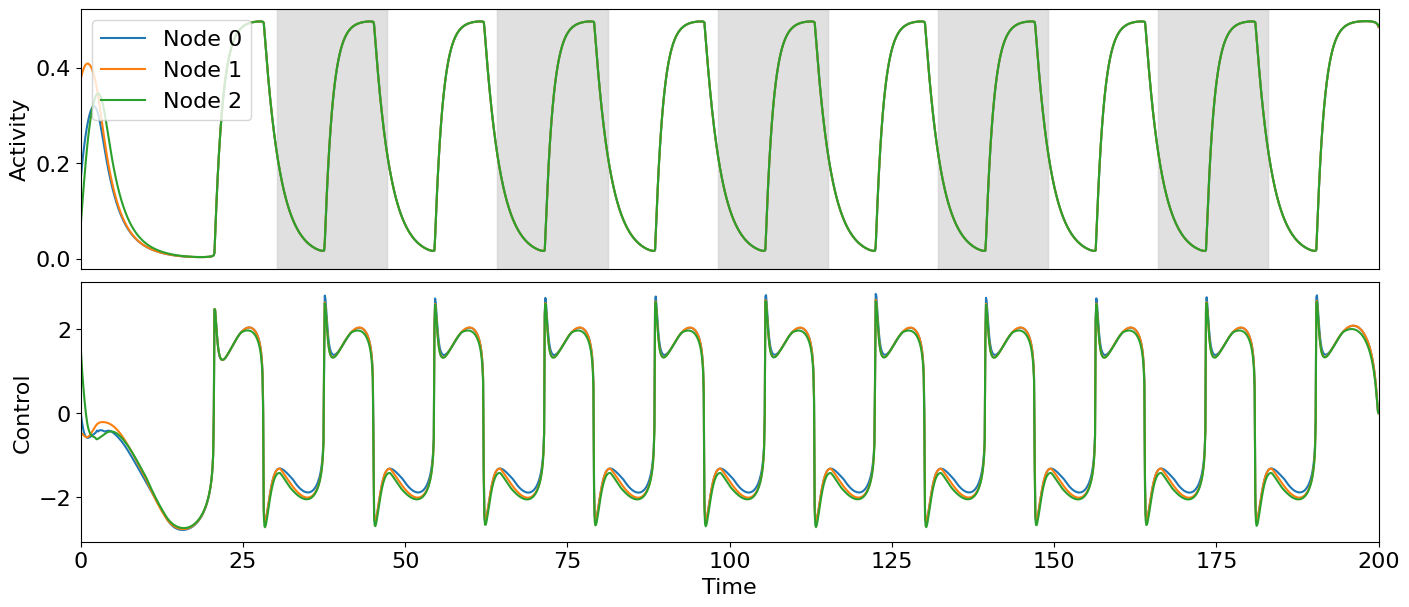

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.6874351615526157
Cost in iteration 10: -0.6878210068833169
Converged in iteration 20 with cost -0.687875543912287
Final cost : -0.687875543912287


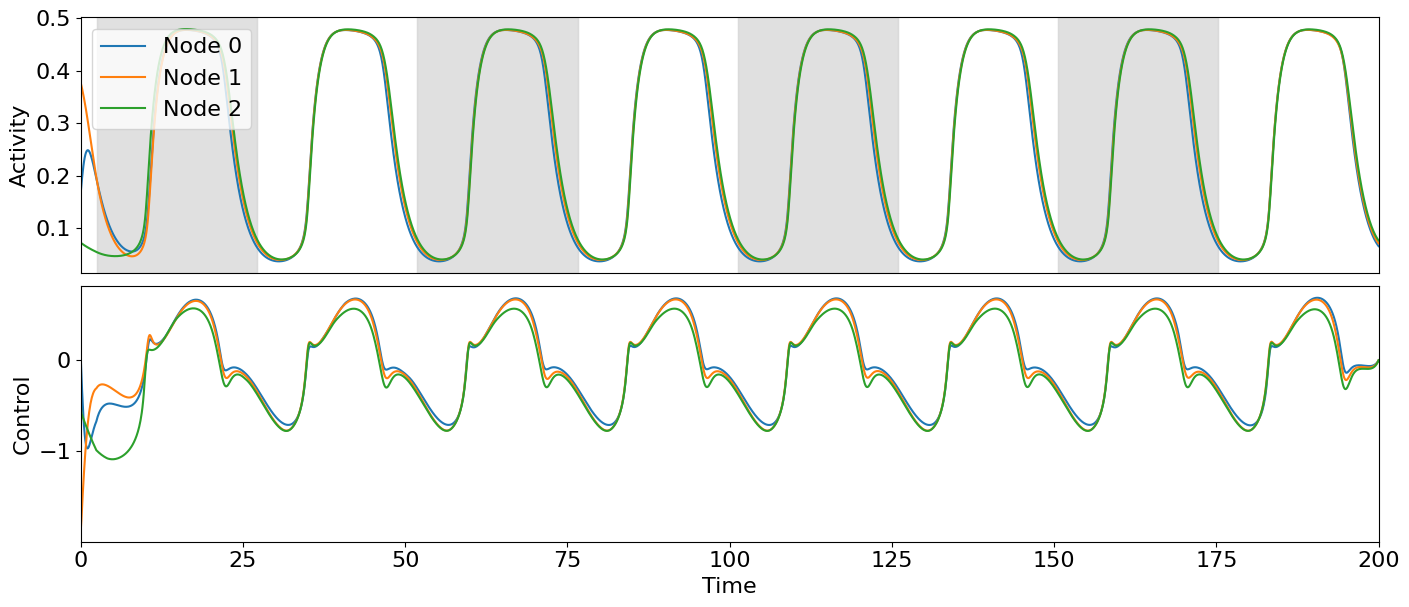

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.8480540181446358
Cost in iteration 10: -0.8481561754582881
Cost in iteration 20: -0.8487607028370447
Cost in iteration 30: -0.8490621606499648
Cost in iteration 40: -0.8491799506435851
Cost in iteration 50: -0.8492325201927097
Cost in iteration 60: -0.8492689141863897
Cost in iteration 70: -0.8492728870796198
Converged in iteration 80 with cost -0.8492728870807457
Final cost : -0.8492728870807457


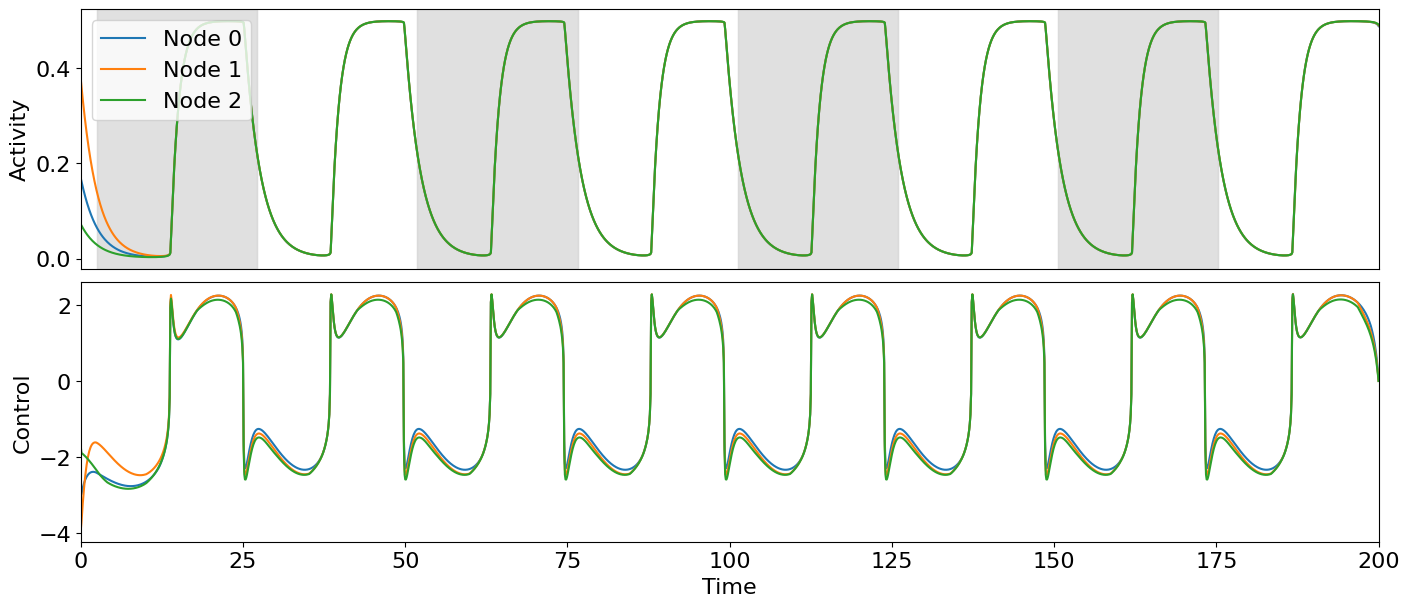

In [13]:
for pind in range(len(comp_points)):

    p = comp_points[pind]
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext"] = test_input + p[0]
    model.params["inh_ext"] = test_input + p[1]
    model.run()

    einit = np.zeros((N, nmaxdel+1))
    iinit = np.zeros((N, nmaxdel+1))


    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration

    model.params["exc_ext"] = zero_control[:,0,:] + p[0]
    model.params["inh_ext"] = zero_control[:,0,:] + p[1]

    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit

    model.run()

    for itar in range(len(target_array)):

        target_period = target_array[itar]
        i00 = 0
        int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
        while int0 > 200:
            i00 += 1
            int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

        for imet in range(4):

            if imet != 0:
                continue

            for iw in range(len(w2_array)):
                
                w2 = w2_array[iw]

                model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
                model_controlled.maximum_control_strength = maxstr
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2

                if imet in [2]:
                    init_control = zero_control.copy()
                    tarray = np.arange(int0*dt, int0*dt + 2.*target_period, dt)
                    init_control[0,0,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)
                    init_control[0,1,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)

                    model_controlled.control = init_control.copy()
                    model_controlled.update_input()

                if imet == 0:
                    model_controlled.weights["w_f_sync"] = 1.
                elif imet == 1:
                    model_controlled.weights["w_cc"] = 1.
                elif imet == 2:
                    model_controlled.weights["w_ko"] = 1.
                elif imet == 3:
                    model_controlled.weights["w_var"] = 1.

                if type(results["controls"][pind][itar][imet][iw]) != type(None):
                    model_controlled.control = results["controls"][pind][itar][imet][iw].copy()
                    model_controlled.update_input()

                model_controlled.optimize(it)
                results["controls"][pind][itar][imet][iw] = model_controlled.control.copy()

                timings, periods = getperiods(model_controlled.get_xs(), proms[iw])
                results["timings"][pind][itar][imet][iw] = timings
                results["periods"][pind][itar][imet][iw] = periods

                fname = str(pind) + "_" + str(itar) + "_" + str(imet) + "_" + str(iw) + ".png"

                if imet == 0: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period, model_controlled.control, filename= os.path.join(dir, fname))
                else: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), 200, model_controlled.control, filename= os.path.join(dir, fname))

In [14]:
with open('snych_3n.pickle', 'wb') as f:
    pickle.dump(results, f)

In [6]:
with open('snych_3n.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings'])


In [15]:
xl = [ ["Down F", "Up F", "Osc F"], ["Down CC", "Up CC", "Osc CC"], ["Down KO", "Up KO", "Osc KO"], ["Down Var", "Up Var", "Osc Var"]]

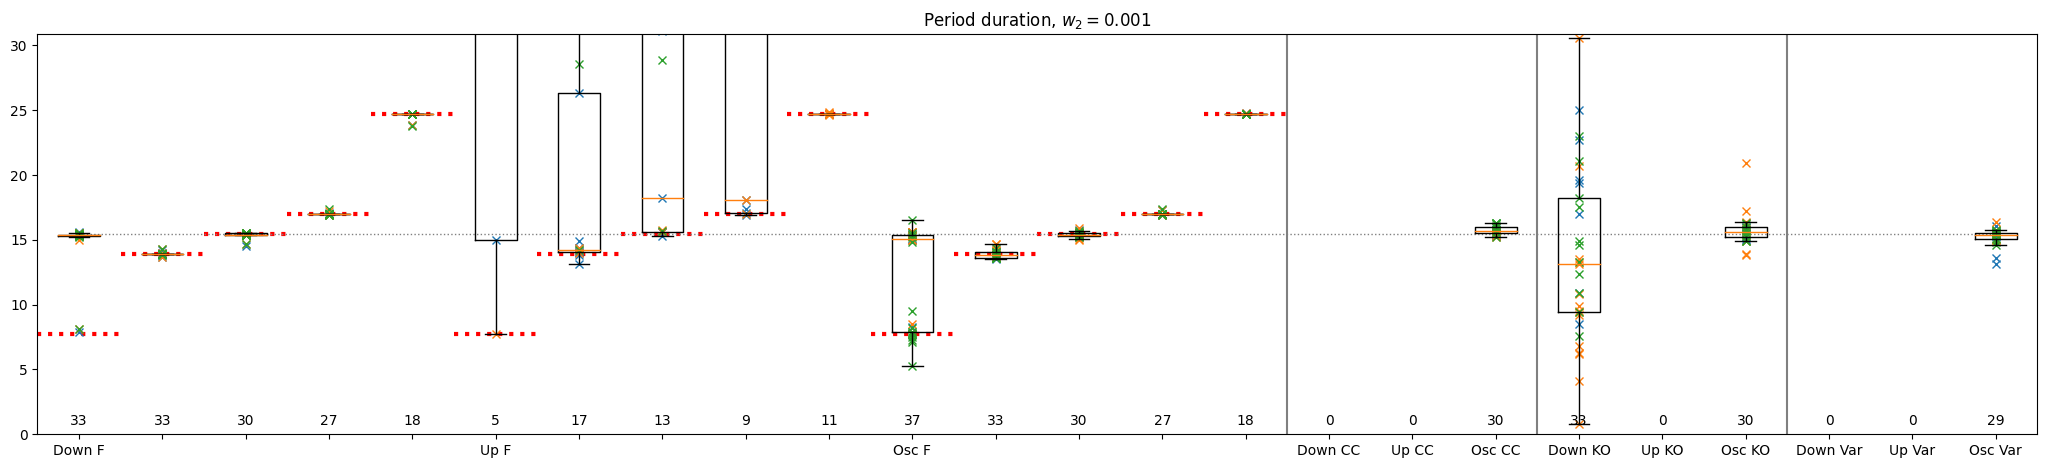

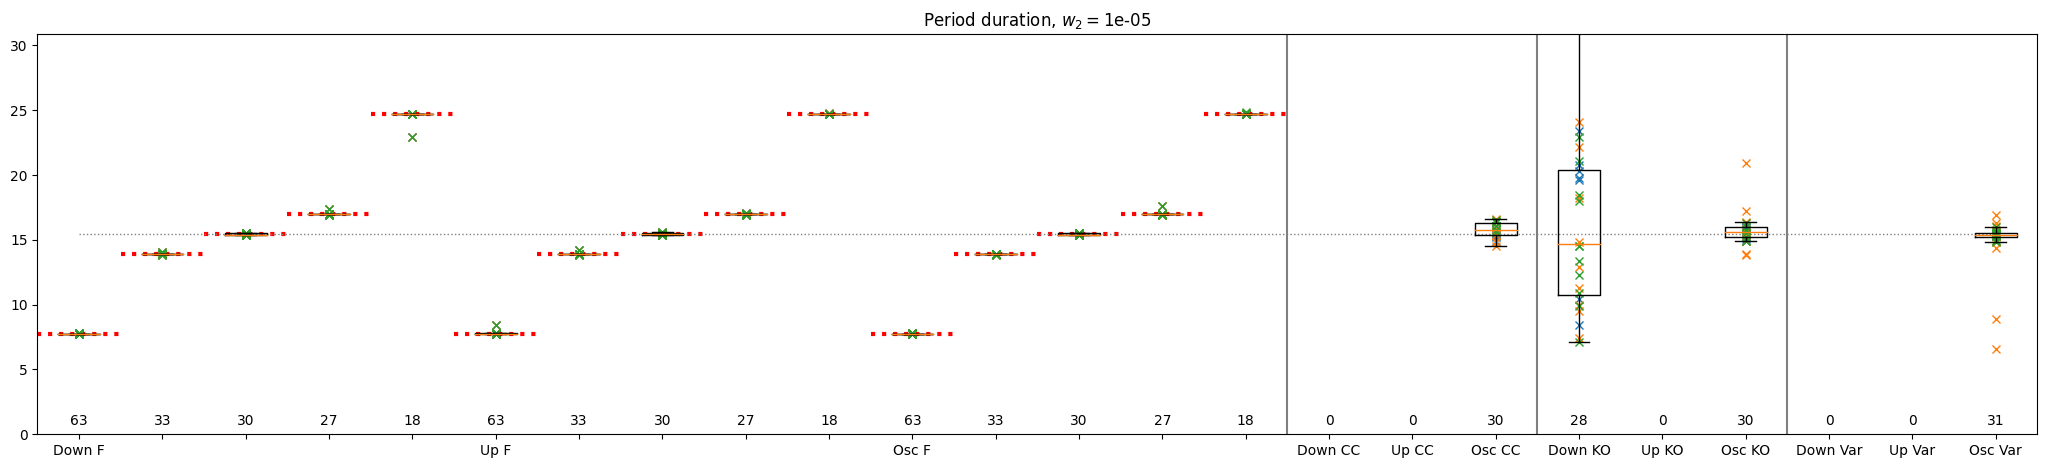

In [16]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(20, 4))
    ax = fig.add_axes([0, 0, 1, 1])

    xpos = 0

    for imet in range(4):

        for pind in range(len(comp_points)):

            for itar in range(len(target_array)):

                if imet not in [0]:
                    if itar not in [2]:
                        continue

                target_period = target_array[itar]
                #xpos = 15*imet + 5*pind + itar 

                if imet in [0]:
                    if itar != 0:
                        xlabels.append("")
                    else:
                        xlabels.append(xl[imet][pind])
                else:
                    xlabels.append(xl[imet][pind])

                data = results["periods"][pind][itar][imet][iw]
                ydata_ = []
                
                if data is None:
                    ydata.append(ydata_)
                    continue

                n_datapoints = 0

                for n in range(N):
                    n_datapoints += len(data[n])
                    
                    if len(data[n]) != 0:
                        for dpoint in data[n]:
                            ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                            ydata_.append(dpoint)

                ydata.append(ydata_)

                ax.text(xpos+1, 1, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
                if xpos < 15: ax.hlines(target_period, xpos+0.5, xpos+1.5, linestyle=":", color="red", linewidth =3)

                xpos += 1


    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.vlines([15.5, 18.5, 21.5], 0., 2.*period, color="grey")
    ax.hlines(period, 1., len(xlabels), linestyle=":", color="grey",linewidth = 1)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(0., 2.*period)
    ax.set_title(r"Period duration, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "periods_" + str(iw) + ".png"), bbox_inches='tight')

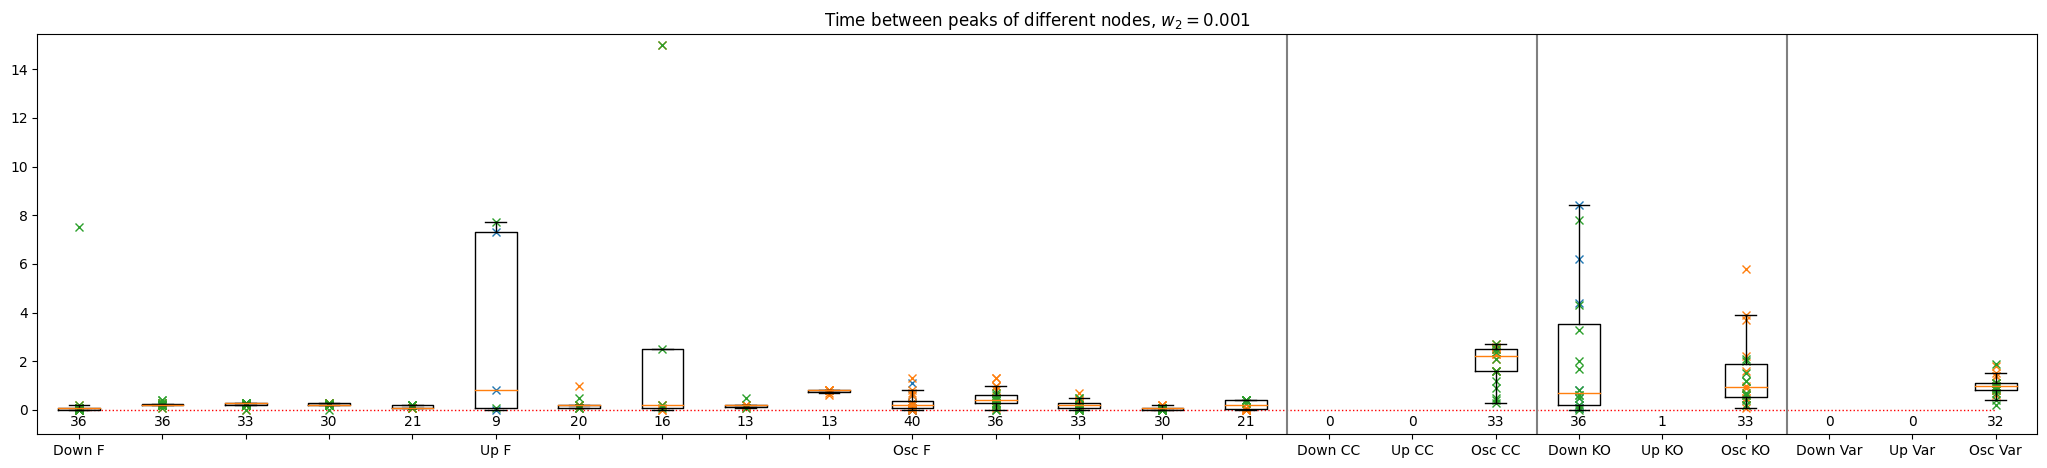

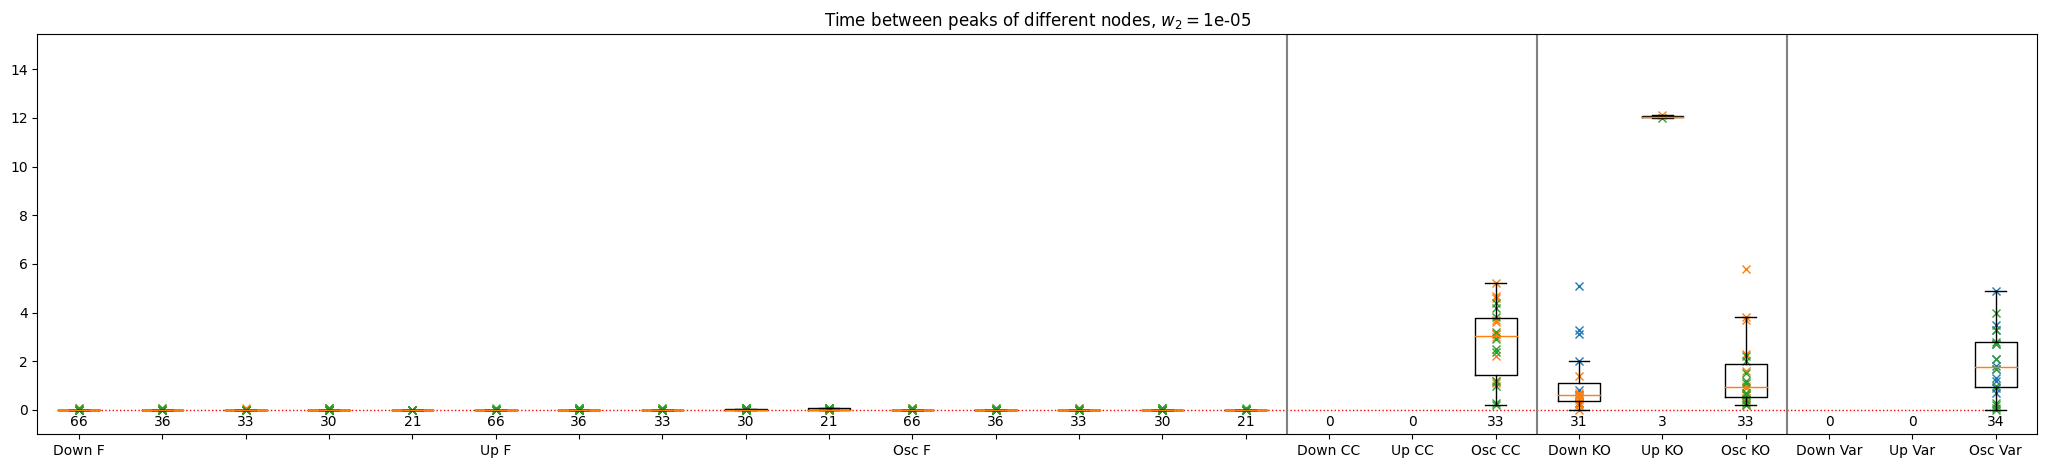

In [17]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(20, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    xpos = 0

    for imet in range(4):

        for pind in range(len(comp_points)):

            for itar in range(len(target_array)):

                if imet not in [0]:
                    if itar not in [2]:
                        continue

                if imet in [0]:
                    if itar != 0:
                        xlabels.append("")
                    else:
                        xlabels.append(xl[imet][pind])
                else:
                    xlabels.append(xl[imet][pind])

                data = results["timings"][pind][itar][imet][iw]
                ydata_ = []

                if data is None:
                    ydata.append(ydata_)
                    continue

                n_maxpeaks = 0

                for n in range(1, N):
                    if len(data[n]) > len(data[n_maxpeaks]):
                        n_maxpeaks = n

                n_datapoints = 0

                for n in range(N):
                    n_datapoints += len(data[n])
                    if n == n_maxpeaks:
                        continue
                    for p in data[n]:
                        dpoint = np.amin(np.abs(p - data[n_maxpeaks])) * dt
                        ydata_.append( dpoint )
                        ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                ax.text(xpos+1, -0.5, str(n_datapoints), horizontalalignment='center', verticalalignment='center')

                ydata.append(ydata_)

                xpos += 1

    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(0., 1., len(xlabels), linestyle=":", color="red",linewidth = 1)
    ax.vlines([15.5, 18.5, 21.5], -1.,period, color="grey")
    ax.set_xticklabels(xlabels)
    ax.set_ylim(-1., period)
    ax.set_title(r"Time between peaks of different nodes, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "timings_" + str(iw) + ".png"), bbox_inches='tight')